<a href="https://colab.research.google.com/github/DanaGoro66/project_simulation/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Water Park Project

In [1]:
from __future__ import annotations
import math
import queue
from re import S
import numpy as np
import copy
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import probplot, norm, kstest, expon
from IPython.display import HTML, display
from google.colab import files
from datetime import time, datetime, timedelta
from collections import deque
import heapq
from typing import Optional, List, Any
import csv
import statistics
GLOBAL_IS_ALT_1 = False
GLOBAL_IS_ALT_2 = False

# כתיבת קוד למציאת התפלגויות ומבחני טיב התאמה לזמני התגלשות במגלשות האבובים הקטנה והגדולה

In [3]:
# =====================================
# 1. Loading data from file
# =====================================

uploaded = files.upload()
excel_file = list(uploaded.keys())[0]
xls = pd.ExcelFile(excel_file)
xls.sheet_names

# Converting the tables to a data structure
big_slide_df   = pd.read_excel(xls, xls.sheet_names[0])
small_slide_df = pd.read_excel(xls, xls.sheet_names[1])

# Taking the time column only and converting to timedelta objects
big_data   = [timedelta(minutes=float(val)) for val in big_slide_df['time_minutes'].values]
small_data = [timedelta(minutes=float(val)) for val in small_slide_df['time_minutes'].values]

alpha = 0.1  # Statistical significance (90% confidence level)

# =====================================
# Helper Functions for Time Conversion
# =====================================

def timedelta_to_minutes(td_list):
    """Convert list of timedelta objects to minutes for plotting/statistics"""
    return [td.total_seconds() / 60 for td in td_list]

def minutes_to_timedelta(minutes_list):
    """Convert list of minutes to timedelta objects"""
    return [timedelta(minutes=float(val)) for val in minutes_list]

# =====================================
# 2. Graphs
# =====================================

def histogram_and_density_line(data, label, ax, candidate_dist=''):
    unified_blue = "#80CEED"
    unified_pink = "#FCB8D6"

    # Convert timedelta to minutes for plotting
    if data and isinstance(data[0], timedelta):
        data_minutes = timedelta_to_minutes(data)
    else:
        data_minutes = data

    # Histogram
    ax.hist(
        data_minutes,
        bins=20,
        edgecolor='black',
        alpha=0.7,
        density=True,
        label='Histogram',
        color=unified_blue
    )

    # Density line
    pd.Series(data_minutes).plot(
        kind='kde',
        color=unified_pink,
        label='Density Line',
        bw_method=0.5,
        ax=ax
    )

    # Headline
    title = f"{label} – Histogram with Density"
    if candidate_dist:
        title += f" (candidate: {candidate_dist})"
    ax.set_title(title, color='dimgray')
    ax.set_xlabel("Time (minutes)", color='dimgray')
    ax.set_ylabel("Density", color='dimgray')
    ax.set_xlim(left=0)
    ax.legend()

## QQ
def QQ_plot_exponential(data, lambda_mle, ax):
    unified_blue = "#80CEED"
    # Convert timedelta to minutes for probplot
    if data and isinstance(data[0], timedelta):
        data_minutes = timedelta_to_minutes(data)
    else:
        data_minutes = data
    # expon: (loc, scale) = (0, 1/lambda)
    probplot(data_minutes, dist="expon", sparams=(0, 1/lambda_mle), plot=ax)
    ax.get_lines()[1].set_color(unified_blue)
    ax.set_title("QQ Plot – Exponential", color='dimgray')

def QQ_plot_normal(data, mu_mle, sigma_mle, ax):
    unified_blue = "#80CEED"
    # Convert timedelta to minutes for probplot
    if data and isinstance(data[0], timedelta):
        data_minutes = timedelta_to_minutes(data)
    else:
        data_minutes = data
    # norm: (loc, scale) = (mu, sigma)
    probplot(data_minutes, dist="norm", sparams=(mu_mle, sigma_mle), plot=ax)
    ax.get_lines()[1].set_color(unified_blue)
    ax.set_title("QQ Plot – Normal", color='dimgray')

## CDF
def CDF_plot_exponential(data, lambda_mle, ax):
    unified_pink = "#FCB8D6"
    unified_blue = "#80CEED"

    # Convert timedelta to minutes for plotting
    if data and isinstance(data[0], timedelta):
        data_minutes = timedelta_to_minutes(data)
    else:
        data_minutes = data

    sorted_data = np.sort(data_minutes)
    n = len(data_minutes)
    empirical_cdf_vals = np.arange(1, n+1) / n
    cdf_fitted = expon.cdf(sorted_data, loc=0, scale=1/lambda_mle)

    ax.plot(
        sorted_data,
        empirical_cdf_vals,
        marker='o',
        linestyle='',
        label='Empirical CDF',
        color=unified_blue
    )
    ax.plot(
        sorted_data,
        cdf_fitted,
        '-',
        label='Fitted Exponential CDF',
        color=unified_pink
    )
    ax.set_title("CDF Comparison – Exponential", color='dimgray')
    ax.set_xlabel("Time (minutes)", color='dimgray')
    ax.set_ylabel("Cumulative Probability", color='dimgray')
    ax.legend(loc='lower right')

def CDF_plot_normal(data, mu_mle, sigma_mle, ax):
    unified_pink = "#FCB8D6"
    unified_blue = "#80CEED"

    # Convert timedelta to minutes for plotting
    if data and isinstance(data[0], timedelta):
        data_minutes = timedelta_to_minutes(data)
    else:
        data_minutes = data

    sorted_data = np.sort(data_minutes)
    n = len(data_minutes)
    empirical_cdf_vals = np.arange(1, n+1) / n
    cdf_fitted = norm.cdf(sorted_data, loc=mu_mle, scale=sigma_mle)

    ax.plot(
        sorted_data,
        empirical_cdf_vals,
        marker='o',
        linestyle='',
        label='Empirical CDF',
        color=unified_blue
    )
    ax.plot(
        sorted_data,
        cdf_fitted,
        '-',
        label='Fitted Normal CDF',
        color=unified_pink
    )
    ax.set_title("CDF Comparison – Normal", color='dimgray')
    ax.set_xlabel("Time (minutes)", color='dimgray')
    ax.set_ylabel("Cumulative Probability", color='dimgray')
    ax.legend(loc='lower right')

# =====================================
# 3. Small Slide – Exponential (graphs & parameters)
# =====================================

# MLE for exponential - convert timedelta to minutes for calculations
small_data_minutes = [td.total_seconds() / 60 for td in small_data]
lambda_small_mle = 1 / np.mean(small_data_minutes)
theoretical_mean_small = 1 / lambda_small_mle

print("=== SMALL SLIDE – Exponential model ===")
print(f"λ_MLE (lambda)            = {lambda_small_mle:.6f}")
print(f"Theoretical mean (1/λ)    = {theoretical_mean_small:.6f}")
print()

display(HTML("<h2 style='text-align: center; color: #FCB8D6;'>Small Slide – Exponential Fit</h2>"))
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

histogram_and_density_line(small_data, "Small slide", axs[0], candidate_dist='Exponential')
QQ_plot_exponential(small_data, lambda_small_mle, axs[1])
CDF_plot_exponential(small_data, lambda_small_mle, axs[2])

plt.tight_layout()
plt.show()

# =====================================
# 4. Big Slide – Normal (graphs & parameters)
# =====================================

# MLE for normal - convert timedelta to minutes for calculations
big_data_minutes = [td.total_seconds() / 60 for td in big_data]
mu_big_mle    = np.mean(big_data_minutes)
sigma_big_mle = np.std(big_data_minutes, ddof=0)
var_big_mle   = sigma_big_mle**2

print("=== BIG SLIDE – Normal model ===")
print(f"μ_MLE (mean)           = {mu_big_mle:.6f}")
print(f"σ^2_MLE (variance)     = {var_big_mle:.6f}")
print(f"σ_MLE (std deviation)  = {sigma_big_mle:.6f}")
print()

display(HTML("<h2 style='text-align: center; color: #FCB8D6;'>Big Slide – Normal Fit</h2>"))
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

histogram_and_density_line(big_data, "Big slide", axs[0], candidate_dist='Normal')
QQ_plot_normal(big_data, mu_big_mle, sigma_big_mle, axs[1])
CDF_plot_normal(big_data, mu_big_mle, sigma_big_mle, axs[2])

plt.tight_layout()
plt.show()

NameError: name 'files' is not defined

# ניתוח ההתפלגות עבור זמן התגלשות במגלשת האבובים הקטנה

**היסטוגרמה:**

כאשר ניתחנו את הנתונים מקובץ האקסל ושמנו אותם על הגרף, נכחנו לגלות כי ההיסטוגרמה מציגה דפוס הדומה להתפלגות אקספוננציאלית - ריכוז התצפיות הגדול ביותר מתכנס סביב הערכים 0-1 דקות וככל שמתקדמים לערכים גבוהים יותר בציר האיקס שמסמן דקות, השכיחות הולכת ונהיית נמוכה יותר, מאפיין התואם להתפלגות אקספוננציאלית.



---

**QQ Plot:**

בגרף זה, ניתן לראות התאמה בעיקר לערכים הנמוכים של ההתפלגות. כאשר נתקדם לערכים גבוהים יותר, יש סטייה של התצפיות מהקו התיאורטי של ההתפלגות, המעידה על אי התאמה חלקית להתפלגות באיזורים הנ"ל.

---

**פונקצייה מצטברת:**

גם בהשוואה הסופית שלנו - בין התצפיות לבין פונקצייה מצטברת של התפלגות אקספוננציאלית, יש התאמה טובה יחסית ונראה כי הרוב המוחלט של התצפיות נמצא על הגרף. נשים לב כי עד ערכי חצי דקה, התצפיות מדויקות יותר וכאשר נתבונן בתצפיות גבוהות יותר, הן הולכות ונהיות יותר מפוזרות.

---

**סיכום:**

המדגם כולל 100 תצפיות, שזהו מדגם קטן יחסית ולמרות זאת, בעזרת הכלים הגרפיים והסטטיסטיים המתאימים נראה כי קיימת סבירות גבוהה לכך שזמן ההתגלשות במגלשת האבובים הקטנה מתפלג אקספוננציאלית.


# MLE for Exponential distribution


##  **פונקציית צפיפות :**

פונקציית הצפיפות של ההתפלגות המעריכית מוגדרת כך:

$$
f(x; \lambda) =
\begin{cases}
\lambda e^{-\lambda x}, & x \geq 0 \\
0, & x < 0
\end{cases}
$$

כאשר הפרמטר של קצב ההתפלגות גדול מאפס.

---

##  **פונקציית הנראות:**

בהינתן מדגם בגודל \( n \):
$$
x_1, x_2, \dots, x_n
$$
פונקציית הנראות היא:

$$
L(\lambda) = \prod_{i=1}^n \lambda e^{-\lambda x_i} = \lambda^n e^{-\lambda \sum_{i=1}^n x_i}
$$

---

##  **פונקציית הלוג של פונקציית הנראות:**

ניקח לוגריתם טבעי (ln) לפונקציית הנראות:

$$
\ell(\lambda) = \ln L(\lambda) = n \ln(\lambda) - \lambda \sum_{i=1}^n x_i
$$

---

##  **מציאת אומדן λ (אומד נראות מקסימלי):**

נגזור את פונקציית הלוג לפי $\lambda$, ונשווה לאפס:

$$
\frac{d\ell(\lambda)}{d\lambda} = \frac{n}{\lambda} - \sum_{i=1}^n x_i = 0
$$

נבודד את $\lambda$:

$$
\lambda = \frac{n}{\sum_{i=1}^n x_i} = \frac{1}{\bar{x}}
$$

כאשר $\bar{x}$ הוא הממוצע של המדגם.

---

##  **מסקנה:**

אומד הנראות המקסימלי של  $\lambda$ הוא:

$$
\lambda_{MLE} = \frac{1}{\bar{x}}
$$

</div>


# ניתוח ההתפלגות עבור זמן התגלשות במגלשת האבובים הגדולה



**היסטוגרמה:**

כאשר ניתחנו את הנתונים מקובץ האקסל ושמנו אותם על הגרף, נכחנו לגלות כי ההיסטוגרמה מציגה דפוס הדומה להתפלגות נורמלית - רוב התצפיות מתכנסות סביב הערכים 3-5 וככל שמתרחקים מערכים אלו, ריכוז התצפיות יורד, באופן יחסית סימטרי, מאפיין התואם להתפלגות נורמלית.



---

**QQ Plot**

בגרף זה ניתן לראות בעיקר התאמה לערכים סביב הממוצע של ההתפלגות. כאשר נתקדם ל-2 זנבות הגרף, יש סטייה של התצפיות מהקו התיאורטי של ההתפלגות, המעידה על אי התאמה חלקית להתפלגות באיזורי הזנבות.

---

**פונקצייה מצטברת:**

גם בהשוואה הסופית שלנו - בין התצפיות לבין פונקצייה מצטברת של התפלגות נורמלית, יש התאמה טובה יחסית ונראה כי הרוב המוחלט של התצפיות נמצא על הגרף או במיקום קרוב יחסית לגרף.

---

**סיכום:**

המדגם כולל 100 תצפיות, שזהו מדגם קטן יחסית ולמרות זאת, בעזרת הכלים הגרפיים והסטטיסטיים המתאימים נראה כי קיימת סבירות גבוהה לכך שזמן ההתגלשות במגלשת האבובים הגדולה מתפלג נורמלית.


# MLE for Normal distribution


## **פונקציית צפיפות:**

התפלגות נורמלית מאופיינת על ידי שני פרמטרים: הממוצע ($\mu$) וסטיית התקן ($\sigma$). פונקציית הצפיפות שלה מוגדרת כך:

$$
f(x; \mu, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(x - \mu)^2}{2 \sigma^2}}
$$

כאשר $\mu \in (-\infty, \infty)$ , $\sigma^2 > 0$.

---

## **פונקציית הנראות:**

בהינתן מדגם של משתנים בלתי תלויים וזהים בהתפלגותם  בגודל $n$:
$$
\mathbf{x} = (x_1, x_2, \dots, x_n)
$$
פונקציית הנראות $L(\mu, \sigma^2)$ היא מכפלת פונקציות הצפיפות עבור כל תצפית:

$$
L(\mu, \sigma^2) = \prod_{i=1}^n f(x_i; \mu, \sigma^2)
$$

נציב את פונקציית הצפיפות הנורמלית:

$$
L(\mu, \sigma^2) = \prod_{i=1}^n \left( \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(x_i - \mu)^2}{2 \sigma^2}} \right)
$$

$$
L(\mu, \sigma^2) = \left( \frac{1}{2 \pi \sigma^2} \right)^{n/2} e^{-\sum_{i=1}^n \frac{(x_i - \mu)^2}{2 \sigma^2}}
$$

---

## **פונקציית הלוג של פונקציית הנראות:**

ניקח לוגריתם טבעי ($\ln$) לפונקציית הנראות ($\ell(\mu, \sigma^2) = \ln L(\mu, \sigma^2)$). הדבר מפשט את המכפלה לסכום:

$$
\ell(\mu, \sigma^2) = \ln \left[ \left( 2 \pi \sigma^2 \right)^{-n/2} \cdot e^{-\frac{1}{2 \sigma^2} \sum_{i=1}^n (x_i - \mu)^2} \right]
$$

על פי חוקי הלוגריתמים: $\ln(a \cdot b) = \ln(a) + \ln(b)$ ו- $\ln(a^b) = b \ln(a)$:

$$
\ell(\mu, \sigma^2) = -\frac{n}{2} \ln(2 \pi \sigma^2) - \frac{1}{2 \sigma^2} \sum_{i=1}^n (x_i - \mu)^2
$$

---

## **מציאת אומדן $\mu$ (אומד נראות מקסימלי):**

נגזור את פונקציית הלוג של הנראות לפי $\mu$ ונשווה לאפס:

$$
\frac{\partial \ell}{\partial \mu} = \frac{\partial}{\partial \mu} \left[ -\frac{n}{2} \ln(2 \pi \sigma^2) - \frac{1}{2 \sigma^2} \sum_{i=1}^n (x_i - \mu)^2 \right] = 0
$$

האיבר הראשון אינו תלוי ב-$\mu$ ולכן נגזרתו אפס. נגזור את האיבר השני:

$$
\frac{\partial \ell}{\partial \mu} = - \frac{1}{2 \sigma^2} \sum_{i=1}^n 2 (x_i - \mu) (-1) = 0
$$

נצמצם ונסדר:

$$
\frac{1}{\sigma^2} \sum_{i=1}^n (x_i - \mu) = 0
$$

מכיוון ש-$\sigma^2 > 0$, נחלק ב-$\frac{1}{\sigma^2}$:

$$
\sum_{i=1}^n (x_i - \mu) = 0
$$

נחלק את הסכום לשני חלקים:

$$
\sum_{i=1}^n x_i - \sum_{i=1}^n \mu = 0
$$

ומכיוון ש-$\mu$ היא קבוע בסכימה:

$$
\sum_{i=1}^n x_i - n \mu = 0
$$

נבודד את $\mu$:

$$
\hat{\mu}_{MLE} = \frac{1}{n} \sum_{i=1}^n x_i
$$

---

## **מציאת אומדן $\sigma^2$ (אומד נראות מקסימלי):**

נגזור את פונקציית הלוג של הנראות לפי $\sigma^2$ (נחשוב על $\sigma^2$ כמשתנה יחיד, נסמנו $v = \sigma^2$) ונשווה לאפס.

$$
\frac{\partial \ell}{\partial v} = \frac{\partial}{\partial v} \left[ -\frac{n}{2} \ln(2 \pi v) - \frac{1}{2 v} \sum_{i=1}^n (x_i - \mu)^2 \right] = 0
$$

נגזור איבר איבר:
* $\frac{\partial}{\partial v} \left[ -\frac{n}{2} \ln(2 \pi v) \right] = -\frac{n}{2} \cdot \frac{1}{2 \pi v} \cdot 2 \pi = -\frac{n}{2 v}$
* $\frac{\partial}{\partial v} \left[ - \frac{1}{2 v} \sum_{i=1}^n (x_i - \mu)^2 \right] = - \sum_{i=1}^n (x_i - \mu)^2 \cdot \frac{\partial}{\partial v} \left( \frac{1}{2} v^{-1} \right) = - \sum_{i=1}^n (x_i - \mu)^2 \cdot \left( -\frac{1}{2} v^{-2} \right) = \frac{1}{2 v^2} \sum_{i=1}^n (x_i - \mu)^2$

נשווה לאפס:

$$
-\frac{n}{2 v} + \frac{1}{2 v^2} \sum_{i=1}^n (x_i - \mu)^2 = 0
$$

נכפיל ב-$2v^2$ ונסדר:

$$
-n v + \sum_{i=1}^n (x_i - \mu)^2 = 0
$$

נבודד את $v$ (שהוא $\sigma^2$):

$$
\hat{v} = \hat{\sigma}^2_{MLE} = \frac{1}{n} \sum_{i=1}^n (x_i - \mu)^2
$$

נציב את אומדן ה-MLE של $\mu$ שמצאנו ($\hat{\mu}_{MLE} = \bar{x}$) במקום $\mu$:

$$
\hat{\sigma}^2_{MLE} = \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^2
$$

---

## **מסקנה:**

אומדי הנראות המקסימליים של הפרמטרים $\mu$ ו-$\sigma^2$ עבור התפלגות נורמלית הם:

* **אומדן $\mu$ (הממוצע):**
$$
\hat{\mu}_{MLE} = \frac{1}{n} \sum_{i=1}^n x_i
$$
* **אומדן $\sigma^2$ (השונות):**
    $$
    \hat{\sigma}^2_{MLE} = \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^2
    $$

---

# מבחני KS לצורך אישור בדיקת התאמת ההתפלגויות

In [ ]:
# =====================================
# 5. KS Goodness-of-Fit Tests
# =====================================

# KS for exponential – Small Slide
ks_stat_small_exp, p_value_small_exp = kstest(small_data_minutes, 'expon', args=(0, 1/lambda_small_mle))

decision_small = "Reject H0" if p_value_small_exp < alpha else "Fail to reject H0"

print("Kolmogorov-Smirnov test – SMALL vs Exponential:")
print(f"KS - D statistic = {ks_stat_small_exp:.6f}")
print(f"p-value      = {p_value_small_exp:.6f}")
print(f"Decision at alpha={alpha}: {decision_small}")
print("\n" + "="*60 + "\n")

# KS for normal – Big Slide
ks_stat_big_norm, p_value_big_norm = kstest(big_data_minutes, 'norm', args=(mu_big_mle, sigma_big_mle))

decision_big = "Reject H0" if p_value_big_norm < alpha else "Fail to reject H0"

print("Kolmogorov-Smirnov test – BIG vs Normal:")
print(f"KS - D statistic = {ks_stat_big_norm:.6f}")
print(f"p-value      = {p_value_big_norm:.6f}")
print(f"Decision at alpha={alpha}: {decision_big}")

## מבחן KS עבור בדיקת התאמה של זמן ההתגלשות במגלשה הקטנה להתפלגות אקפוננציאלית

הסטטיסטי שיצא במבחן:

$D = 0.068455$

מובהקות התוצאה:

$P_{\text{value}} = 0.710573$

רמת מובהקות המבחן:

10%

מכיוון ש־$0.1 < P_{\text{value}}$, **אין לנו מספיק עדות לדחות את השערת האפס**, ולכן ניתן לומר שהנתונים מתאימים להתפלגות אקספוננציאלית עם הפרמטר שחושב.


---




## מבחן KS עבור בדיקת התאמה של זמן ההתגלשות במגלשה הגדולה להתפלגות נורמלית

הסטטיסטי שיצא במבחן:

$D = 0.036953$

מובהקות התוצאה:

$P_{\text{value}} = 0.998451$

רמת מובהקות המבחן:

10%

מכיוון ש־$0.1 < P_{\text{value}}$, **אין לנו מספיק עדות לדחות את השערת האפס**, ולכן ניתן לומר שהנתונים מתאימים להתפלגות נורמלית עם הפרמטרים שחושבו.


---




# Sampling Algorithms

### 1. Distribution of the Number of Children in a Family
Let $X$ be the age, which follows a discrete uniform distribution
for the integer range $[a, b]$, where: $a=1, b=5$



**Total number of outcomes:**
$$
n = b - a + 1 = 5 - 1 + 1 = 5
$$

**Probability for each individual value:**
$$
P(X=k) = \frac{1}{n} = \frac{1}{5}
$$

**The Transformation:**
To obtain discrete values from the continuous variable $U$, we divide the interval $[0,1]$ into $n$ equal parts and use the **floor function** to ensure rounding down (as the number of children must be an integer):

$$
x = a + \lfloor (b - a + 1) \cdot U \rfloor
$$

For the given data ($a=1, n=5$):
$$
x = 1 + \lfloor 5U \rfloor
$$

## Sampling Algorithm:
1. Sample $U \sim U[0,1)$.
2. Return $x = 1 + \lfloor 5U \rfloor$.


##

### 2. Distribution Of Children's Age
Let $X$ be the age, which follows a Continuous Uniform Distribution
for the range $[a, b]$ where: $a=2, b=18$


**Probability Density Function (PDF):**
$$
f(x) = \frac{1}{b - a} = \frac{1}{18-2}= \frac{1}{16}
$$

**Cumulative Distribution Function (CDF) for Continuous Uniform:**
$$
F(x) = \frac{x - a}{b - a} = u
$$

**Solving for $x$:**
$$
x - a = u(b - a) \\
x = a + (b - a)u
$$

For the given values ($a=2, b=18$):
$$
x = 2 + 16u
$$

## Sampling Algorithm:
1. Sample $U \sim [0,1]$.
2. Return $x = 2 + 16u$.

##

##3. Family Arrival Rate

## Probability Density Function
Let $X$ be the time until the family leaves, following an Exponential distribution with rate parameter $\lambda = \frac{3}{2}$.
$$
f(x) = \begin{cases}
\frac{3}{2}e^{-\frac{3}{2}x} & x \ge 0 \\
0 & \text{else}
\end{cases}
$$

## Calculating the Cumulative Distribution Function:
We calculate the CDF by integrating the PDF from the lower bound ($0$) to $x$:


$$
F(x) = \int_{0}^{x} \frac{3}{2}e^{-\frac{3}{2}t} \, dt = \left[ -e^{-\frac{3}{2}t} \right]_{0}^{x} = \left( -e^{-\frac{3}{2}x} \right) - \left( -e^{0} \right) = 1 - e^{-\frac{3}{2}x}
$$



### Finding $x$ (Inverse Transform)
To generate samples, we find the inverse function by setting $F(x) = u$ and solving for $x$:

$$
1 - e^{-\frac{3}{2}x} = u
$$


$$
e^{-\frac{3}{2}x} = 1 - u
$$

Take the natural logarithm ($\ln$) of both sides:
$$
-\frac{3}{2}x = \ln(1 - u)
$$


$$
x = -\frac{2}{3}\ln(1 - u)
$$



## Sampling Algorithm
1.Generate a random number $U$ from a uniform distribution: $U \sim [0,1]$.

2.Calculate $x$ using the derived formula: $$x = -\frac{2}{3}\ln(1 - U)$$
   

##

## 4. Family Leaving Time
## Probability Density Function
The PDF as given:

$$
f(x) = \begin{cases}
\frac{2}{9}(x - 16) & 16 \le x \le 19 \\
0 & \text{else}
\end{cases}
$$

## Calculating the Cumulative Distribution Function
We calculate the CDF by integrating the PDF from the lower bound (16) to $x$.
The integration steps are condensed below:

$$
F(x) = \int_{16}^{x} \frac{2}{9}(t - 16) \, dt = \left[ \frac{t^2}{9} - \frac{32t}{9} \right]_{16}^{x} = \left( \frac{x^2}{9} - \frac{32x}{9} \right) - \left( \frac{256}{9} - \frac{512}{9} \right) = \frac{x^2}{9} - \frac{32x}{9} + \frac{256}{9}
$$

---

### Finding $x$ (Inverse Transform)
To find the inverse function, we set $F(x) = u$ and solve for $x$.
$$
\frac{x^2}{9} - \frac{32x}{9} + \frac{256}{9} = u \quad \Rightarrow \quad x^2 - 32x + (256 - 9u) = 0
$$

Using the quadratic formula (selecting the positive root since $x \ge 16$):
$$
x = \frac{32 + \sqrt{(-32)^2 - 4(1)(256 - 9u)}}{2} = \frac{32 + \sqrt{36u}}{2} = \frac{32 + 6\sqrt{u}}{2}
$$

$$
x = 16 + 3\sqrt{u}
$$

## Sampling Algorithm
1. Generate $U$ from a uniform distribution: $U \sim [0,1]$.
2. Calculate $x$ using the derived formula:  $$x = 16 + 3\sqrt{U}$$

###

###5. Number Of Teenagers In Group
## Sampling Algorithm

1. Generate $U$ from a uniform distribution: $U \sim [0,1]$.
  

2. Determine the value of $X$ based on the interval in which $U$ falls:

   * If $0 \le U \le 0.20$ $\Rightarrow$ Return $X = 2$
   * Else If $0.20 < U \le 0.4$ $\Rightarrow$ Return $X = 3$
   * Else If $0.40 < U \le 0.65$ $\Rightarrow$ Return $X = 4$
   * Else If $0.65 < U \le 0.90$ $\Rightarrow$ Return $X = 5$
   * Else  $\Rightarrow$ Return $X = 6$


   ##

###6. Teenagers Arrival Rate

## Probability Density Function
Let $X$ be the time teengares arrive, following an Exponential distribution with rate parameter $\lambda = \frac{18}{25}$.
$$
f(x) = \begin{cases}
\frac{18}{25}e^{-\frac{18}{25}x} & x \ge 0 \\
0 & \text{else}
\end{cases}
$$

## Calculating the Cumulative Distribution Function:
We calculate the CDF by integrating the PDF from the lower bound ($0$) to $x$:

$$
F(x) = \int_{0}^{x} \frac{18}{25}e^{-\frac{18}{25}t} \, dt = \left[ -e^{-\frac{18}{25}t} \right]_{0}^{x} = \left( -e^{-\frac{18}{25}x} \right) - \left( -e^{0} \right) = 1 - e^{-\frac{18}{25}x}
$$

### Finding $x$ (Inverse Transform)
To generate samples, we find the inverse function by setting $F(x) = u$ and solving for $x$:

$$
1 - e^{-\frac{18}{25}x} = u
$$

$$
e^{-\frac{18}{25}x} = 1 - u
$$

Take the natural logarithm ($\ln$) of both sides:
$$
-\frac{18}{25}x = \ln(1 - u)
$$

$$
x = -\frac{25}{18}\ln(1 - u)
$$

## Sampling Algorithm
1.Generate a random number $U$ from a uniform distribution: $U \sim [0,1]$.

2.Calculate $x$ using the derived formula: $$x = -\frac{25}{18}\ln(1 - U)$$

##

###7. Solo Visitors Arrival Rate


## Probability Density Function
Let $X$ be the time solo visitors arrive, following an Exponential distribution with rate parameter $\lambda = \frac{3}{2}$.
$$
f(x) = \begin{cases}
\frac{3}{2}e^{-\frac{3}{2}x} & x \ge 0 \\
0 & \text{else}
\end{cases}
$$

## Calculating the Cumulative Distribution Function:
We calculate the CDF by integrating the PDF from the lower bound ($0$) to $x$:


$$
F(x) = \int_{0}^{x} \frac{3}{2}e^{-\frac{3}{2}t} \, dt = \left[ -e^{-\frac{3}{2}t} \right]_{0}^{x} = \left( -e^{-\frac{3}{2}x} \right) - \left( -e^{0} \right) = 1 - e^{-\frac{3}{2}x}
$$



### Finding $x$ (Inverse Transform)
To generate samples, we find the inverse function by setting $F(x) = u$ and solving for $x$:

$$
1 - e^{-\frac{3}{2}x} = u
$$


$$
e^{-\frac{3}{2}x} = 1 - u
$$

Take the natural logarithm ($\ln$) of both sides:
$$
-\frac{3}{2}x = \ln(1 - u)
$$


$$
x = -\frac{2}{3}\ln(1 - u)
$$



## Sampling Algorithm
1.Generate a random number $U$ from a uniform distribution: $U \sim [0,1]$.

2.Calculate $x$ using the derived formula: $$x = -\frac{2}{3}\ln(1 - U)$$
   
##

###8. Buying A Ticket

Let $X$ be the time buying a ticket, which follows a Continuous Uniform Distribution for the range $[a, b]$ where: $a=5, b=10$


Probability Density Function :
$$
f(x) = \frac{1}{b - a} = \frac{1}{10-5}= \frac{1}{5}
$$

**Cumulative Distribution Function (CDF) for Continuous Uniform:**
$$
F(x) = \frac{x - a}{b - a} = u
$$

**Solving for $x$:**
$$
x - a = u(b - a) \\
x = a + (b - a)u
$$

For the given values ($a=5, b=10$):
$$
x = 5 + 10u
$$

## Sampling Algorithm:
1. Sample $U \sim [0,1]$.
2. Return $x = 5 + 10u$.
##

###9. Bracelet Time


## Probability Density Function
Let $X$ be the time until the family leaves, following an Exponential distribution with rate parameter $\lambda = \frac{1}{2}$.
$$
f(x) = \begin{cases}
\frac{1}{2}e^{-\frac{1}{2}x} & x \ge 0 \\
0 & \text{else}
\end{cases}
$$

## Calculating the Cumulative Distribution Function:
We calculate the CDF by integrating the PDF from the lower bound ($0$) to $x$:

$$
F(x) = \int_{0}^{x} \frac{1}{2}e^{-\frac{1}{2}t} \, dt = \left[ -e^{-\frac{1}{2}t} \right]_{0}^{x} = \left( -e^{-\frac{1}{2}x} \right) - \left( -e^{0} \right) = 1 - e^{-\frac{1}{2}x}
$$

### Finding $x$ (Inverse Transform)
To generate samples, we find the inverse function by setting $F(x) = u$ and solving for $x$:

$$
1 - e^{-\frac{1}{2}x} = u
$$

$$
e^{-\frac{1}{2}x} = 1 - u
$$

Take the natural logarithm ($\ln$) of both sides:
$$
-\frac{1}{2}x = \ln(1 - u)
$$

$$
x = -2\ln(1 - u)
$$

## Sampling Algorithm
1.Generate a random number $U$ from a uniform distribution: $U \sim [0,1]$.

2.Calculate $x$ using the derived formula: $$x = -2\ln(1 - U)$$

##

## 12. Small Tube Watersilde
Let $X$ be the ride's sliding time, following an Exponential distribution with rate parameter $\lambda = 2.107060$.
$$
f(x) = \begin{cases}
2.107060e^{-2.107060x} & x \ge 0 \\
0 & \text{else}
\end{cases}
$$

## Calculating the Cumulative Distribution Function:
We calculate the CDF by integrating the PDF from the lower bound ($0$) to $x$:


$$
F(x) = \int_{0}^{x} 2.107060e^{-2.107060t} \, dt = \left[ -e^{-2.107060t} \right]_{0}^{x} = \left( -e^{-2.107060x} \right) - \left( -e^{0} \right) = 1 - e^{-2.107060x}
$$



### Finding $x$ (Inverse Transform)
To generate samples, we find the inverse function by setting $F(x) = u$ and solving for $x$:

$$
1 - e^{-2.107060x} = u
$$


$$
e^{-2.107060x} = 1 - u
$$

Take the natural logarithm ($\ln$) of both sides:
$$
-2.107060x = \ln(1 - u)
$$


$$
x = -0.474595\ln(1 - u)
$$



## Sampling Algorithm
1.Generate a random number $U$ from a uniform distribution: $U \sim [0,1]$.

2.Calculate $x$ using the derived formula: $$x = -0.474595\ln(1 - U)$$

## 10. LazyRiver


Let $X$ be the time riding the Lazy River ride, which follows a Continuous Uniform Distribution
for the range $[a, b]$ where: $a=2, b=18$


**Probability Density Function (PDF):**
$$
f(x) = \frac{1}{b - a} = \frac{1}{30-20}= \frac{1}{10}
$$

**Cumulative Distribution Function (CDF) for Continuous Uniform:**
$$
F(x) = \frac{x - a}{b - a} = u
$$

**Solving for $x$:**
$$
x - a = u(b - a) \\
x = a + (b - a)u
$$

For the given values ($a=20, b=30$):
$$
x = 20 + 10u
$$

### Sampling Algorithm:
1. Sample $U \sim [0,1]$.
2. Return $x = 20 + 10u$.








### 11. Big Tube Watersilde

Let $X$ be the time (minutes), which follows a **Normal Distribution** $N(\mu, \sigma^2)$ where: $\mu=4.800664, \sigma=1.823101$.

**Probability Density Function (PDF):**
$$
f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2} \left(\frac{x - \mu}{\sigma}\right)^2}
$$
For the given values ($\mu=4.800664, \sigma=1.823101$):
$$
f(x) = \frac{1}{1.823101 \sqrt{2\pi}} e^{-\frac{1}{2} \left(\frac{x - 4.800664}{1.823101}\right)^2}
$$

**Cumulative Distribution Function (CDF) for Normal:**
The CDF is given by the formula involving the standard normal CDF, $\Phi(z)$:
$$
F(x) = P(X \le x) = \Phi(z) \text{ where } z = \frac{x - \mu}{\sigma}
$$

**Transformation for Sampling:**
To sample $X$ from $N(\mu, \sigma^2)$, we transform a sample $Z$ from the Standard Normal Distribution $N(0, 1)$ using the relationship:
$$
X = \mu + \sigma Z
$$

For the given values ($\mu=4.800664, \sigma=1.823101$):
$$
X = 4.800664 + 1.823101 Z
$$

**Box-Muller Transform for Standard Normal:**
To generate $Z \sim N(0, 1)$, we use the Box-Muller transform with two independent uniform random variables $U_1, U_2 \sim U[0,1]$:
$$
Z = \sqrt{-2\ln(U_1)} \cdot \sin(2\pi U_2)
$$

## Sampling Algorithm:
1. Generate $U_1, U_2 \sim U[0,1]$.
2. Calculate $Z = \sqrt{-2\ln(U_1)} \cdot \sin(2\pi U_2)$.
3. Return $x = 4.800664 + 1.823101 Z$.


###12. Making a Hamburger

Let $X$ be the time to make a hamburger, which follows a Continuous Uniform Distribution for the range $[a, b]$ where: $a=3, b=4$


Probability Density Function :
$$
f(x) = \frac{1}{b - a} = \frac{1}{4-3}= 1
$$

**Cumulative Distribution Function (CDF) for Continuous Uniform:**
$$
F(x) = \frac{x - a}{b - a} = u
$$

**Solving for $x$:**
$$
x - a = u(b - a) \\
x = a + (b - a)u
$$

For the given values ($a=3, b=4$):
$$
x = 3 + (4 - 3)u \\
x = 3 + u
$$

## Sampling Algorithm:
1. Sample $U \sim [0,1]$.
2. Return $x = 3 + u$.

##

## 13. WavePool

### Acceptance–Rejection Sampling
Because the WavePool ride time follows a piecewise PDF that does not allow a closed-form inverse CDF, we use the **Acceptance–Rejection method** to generate valid samples.

The target PDF \( f(x) \) is defined as:
$$
f(x) = \begin{cases}
\frac{X}{2700} & 0 \le x \le 30 \\
\frac{60-X}{2700}+ \frac{1}{30} & 30 \le x \le 50 \\
\frac{60-X}{2700} & 50 \le x \le 60 \\
0 & \text{else}
\end{cases}
$$

The maximum value of \( f(x) \) occurs at \( x = 30 \):

$$
t(x) =  f_{\max} = f(30^+) = \frac{2}{45}
$$

### Bounding Constant \( c \)

We require a constant \( c \) such that:
$$
f(x) \le c\, g(x)
$$

Since
$$
( g(x) = \frac{1}{60} )$$ and $$( \max f(x) = \frac{2}{45} )$$, we get:


$$
c = 60 \cdot \frac{2}{45} = \frac{8}{3}
$$




### Acceptance–Rejection Algorithm
1. Sample $$( U1 \sim [0, 1] ) $$
and set $$X = 60 \cdot U_1$$
2. Sample $$( U2 \sim [0, 1] ) $$
3. Compute $$( f(X) )$$ using the piecewise definition.  
4. Accept $$( X ) $$ if:
   $$[
   U2 \le \frac{f(X)}{c\, g(X)} = \frac{f(X)}{2/45} = \frac{45}{2}\, f(X)
   ]$$
5. If rejected, repeat from step 1.


## 14. Kids Pool

### Probability Density Function
The probability density function (PDF) is defined as:

$$
f(x)=
\begin{cases}
\frac{16}{3}(x-1) & 1 \le x \le 1.25 \\[6pt]
\frac{4}{3} & 1.25 < x \le 1.75 \\[6pt]
\frac{16}{3}(2-x) & 1.75 < x \le 2 \\[6pt]
0 & \text{else}
\end{cases}
$$



### Calculating the Cumulative Distribution Function

#### Case 1: \(1 \le x \le 1.25\)

$$
F(x)=\int_{1}^{x}\frac{16}{3}(t-1)\,dt
=\frac{8}{3}(x-1)^2
$$



#### Case 2: \(1.25 < x \le 1.75\)

$$
F(1.25)=\frac{8}{3}(0.25)^2=\frac{1}{6}
$$

$$
F(x)=\frac{1}{6}+\int_{1.25}^{x}\frac{4}{3}\,dt
=\frac{1}{6}+\frac{4}{3}(x-1.25)
$$



#### Case 3: \(1.75 < x \le 2\)

$$
F(1.75)=\frac{1}{6}+\frac{4}{3}(0.5)=\frac{5}{6}
$$

$$
F(x)=\frac{5}{6}+\int_{1.75}^{x}\frac{16}{3}(2-t)\,dt
$$



### Finding \(x\) (Inverse Transform)

The distribution is sampled using a mixture approach.

$$
p_1=\frac{1}{6}, \quad
p_2=\frac{2}{3}, \quad
p_3=\frac{1}{6}
$$



#### Segment 1: \(1 \le x \le 1.25\)

$$
F_1(x)=16(x-1)^2
$$

$$
x=1+\frac{1}{4}\sqrt{u}
$$



#### Segment 2: \(1.25 < x \le 1.75\)

$$
F_2(x)=2(x-1.25)
$$

$$
x=1.25+\frac{u}{2}
$$



#### Segment 3: \(1.75 < x \le 2\)

$$
F_3(x)=1-16(2-x)^2
$$

$$
x=2-\frac{1}{4}\sqrt{1-u}
$$



### Sampling Algorithm

1. Generate \(U \sim \text{Uniform}(0,1)\).
2. If \(U < \frac{1}{6}\):
   - Set \(u = 6U\)
   - Sample:
     $$
     x = 1 + \frac{1}{4}\sqrt{u}
     $$
3. Else if \(U < \frac{5}{6}\):
   - Set:
     $$
     u = \frac{3}{2}\left(U - \frac{1}{6}\right)
     $$
   - Sample:
     $$
     x = 1.25 + \frac{u}{2}
     $$
4. Else:
   - Set:
     $$
     u = 6\left(U - \frac{5}{6}\right)
     $$
   - Sample:
     $$
     x = 2 - \frac{1}{4}\sqrt{1-u}
     $$


## 15. Snorkeling Tour

### Distribution Of Tour's Time

Let $X$ be the time (minutes) , which follows a **Normal Distribution** $N(\mu, \sigma^2)$ where: $\mu=30, \sigma=10$.

**Probability Density Function (PDF):**
$$
f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2} \left(\frac{x - \mu}{\sigma}\right)^2}
$$
For the given values ($\mu=30, \sigma=10$):
$$
f(x) = \frac{1}{10 \sqrt{2\pi}} e^{-\frac{1}{2} \left(\frac{x - 30}{10}\right)^2}
$$

**Cumulative Distribution Function (CDF) for Normal:**
The CDF is given by the formula involving the standard normal CDF, $\Phi(z)$:
$$
F(x) = P(X \le x) = \Phi(z) \text{ where } z = \frac{x - \mu}{\sigma}
$$

**Transformation for Sampling:**
To sample $X$ from $N(\mu, \sigma^2)$, we transform a sample $Z$ from the Standard Normal Distribution $N(0, 1)$ using the relationship:
$$
X = \mu + \sigma Z
$$

For the given values ($\mu=30, \sigma=10$):
$$
X = 30 + 10 Z
$$

**Box-Muller Transform for Standard Normal:**
To generate $Z \sim N(0, 1)$, we use the Box-Muller transform with two independent uniform random variables $U_1, U_2 \sim U[0,1]$:
$$
Z = \sqrt{-2\ln(U_1)} \cdot \sin(2\pi U_2)
$$

## Sampling Algorithm:
1. Generate $U_1, U_2 \sim U[0,1]$.
2. Calculate $Z = \sqrt{-2\ln(U_1)} \cdot \sin(2\pi U_2)$.
3. Return $x = 30 + 10 Z$.

###13. Making a Salad

Let $X$ be the time to make a salad, which follows a Continuous Uniform Distribution for the range $[a, b]$ where: $a=3, b=7$


Probability Density Function :
$$
f(x) = \frac{1}{b - a} = \frac{1}{7-3}= \frac{1}{4}
$$

**Cumulative Distribution Function (CDF) for Continuous Uniform:**
$$
F(x) = \frac{x - a}{b - a} = u
$$

**Solving for $x$:**
$$
x - a = u(b - a) \\
x = a + (b - a)u
$$

For the given values ($a=3, b=7$):
$$
x = 3 + (7 - 3)u \\
x = 3 + 4u
$$

## Sampling Algorithm:
1. Sample $U \sim [0,1]$.
2. Return $x = 3 + 4u$.

##

### 14. Service Time

Let $X$ be the service time, which follows a **Normal Distribution** $N(\mu, \sigma^2)$ where: $\mu=5, \sigma=1.5$.

**Probability Density Function (PDF):**
$$
f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2} \left(\frac{x - \mu}{\sigma}\right)^2}
$$
For the given values ($\mu=5, \sigma=1.5$):
$$
f(x) = \frac{1}{1.5 \sqrt{2\pi}} e^{-\frac{1}{2} \left(\frac{x - 5}{1.5}\right)^2}
$$

**Cumulative Distribution Function (CDF) for Normal:**
The CDF is given by the formula involving the standard normal CDF, $\Phi(z)$:
$$
F(x) = P(X \le x) = \Phi(z) \text{ where } z = \frac{x - \mu}{\sigma}
$$

**Transformation for Sampling:**
To sample $X$ from $N(\mu, \sigma^2)$, we transform a sample $Z$ from the Standard Normal Distribution $N(0, 1)$ using the relationship:
$$
X = \mu + \sigma Z
$$

For the given values ($\mu=5, \sigma=1.5$):
$$
X = 5 + 1.5 Z
$$

## Sampling Algorithm:
1. Sample $Z$ from a Standard Normal Distribution $N(0, 1)$.
2. Return $x = 5 + 1.5 Z$.

##

##16. Eating Time

Let $X$ be the time to eat, which follows a Continuous Uniform Distribution for the range $[a, b]$ where: $a=15, b=35$

**Probability Density Function :
$$
f(x) = \frac{1}{b - a} = \frac{1}{35-15}= \frac{1}{20}
$$
]

Cumulative Distribution Function  for Continuous Uniform:
$$
F(x) = \frac{x - a}{b - a} = u
$$

Solving for $x$:
$$
x - a = u(b - a) \\
x = a + (b - a)u
$$

For the given values ($a=15, b=35$):
$$
x = 15 + (35 - 15)u \\
x = 15 + 20u
$$

## Sampling Algorithm:
1. Sample $U \sim [0,1]$.
2. Return $x = 15 + 20u$.

###17. Pizza Making Time

Let $X$ be the time to make a pizza, which follows a Continuous Uniform Distribution for the range $[a, b]$ where: $a=4, b=6$


Probability Density Function :
$$
f(x) = \frac{1}{b - a} = \frac{1}{6-4}= \frac{1}{2}
$$

**Cumulative Distribution Function (CDF) for Continuous Uniform:**
$$
F(x) = \frac{x - a}{b - a} = u
$$

**Solving for $x$:**
$$
x - a = u(b - a) \\
x = a + (b - a)u
$$

For the given values ($a=4, b=6$):
$$
x = 4 + (6 - 4)u \\
x = 4 + 2u
$$

## Sampling Algorithm:
1. Sample $U \sim [0,1]$.
2. Return $x = 4 + 2u$.

###18. Making a Hamburger

Let $X$ be the time to make a hamburger, which follows a Continuous Uniform Distribution for the range $[a, b]$ where: $a=3, b=4$


Probability Density Function :
$$
f(x) = \frac{1}{b - a} = \frac{1}{4-3}= 1
$$

**Cumulative Distribution Function (CDF) for Continuous Uniform:**
$$
F(x) = \frac{x - a}{b - a} = u
$$

**Solving for $x$:**
$$
x - a = u(b - a) \\
x = a + (b - a)u
$$

For the given values ($a=3, b=4$):
$$
x = 3 + (4 - 3)u \\
x = 3 + u
$$

## Sampling Algorithm:
1. Sample $U \sim [0,1]$.
2. Return $x = 3 + u$.

###19. Making a Salad

Let $X$ be the time to make a salad, which follows a Continuous Uniform Distribution for the range $[a, b]$ where: $a=3, b=7$


Probability Density Function :
$$
f(x) = \frac{1}{b - a} = \frac{1}{7-3}= \frac{1}{4}
$$

**Cumulative Distribution Function (CDF) for Continuous Uniform:**
$$
F(x) = \frac{x - a}{b - a} = u
$$

**Solving for $x$:**
$$
x - a = u(b - a) \\
x = a + (b - a)u
$$

For the given values ($a=3, b=7$):
$$
x = 3 + (7 - 3)u \\
x = 3 + 4u
$$

## Sampling Algorithm:
1. Sample $U \sim [0,1]$.
2. Return $x = 3 + 4u$.

### 20. Service Time

Let $X$ be the age, which follows a **Normal Distribution** $N(\mu, \sigma^2)$ where: $\mu=5, \sigma=1.5$.

**Probability Density Function (PDF):**
$$
f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2} \left(\frac{x - \mu}{\sigma}\right)^2}
$$
For the given values ($\mu=5, \sigma=1.5$):
$$
f(x) = \frac{1}{1.5 \sqrt{2\pi}} e^{-\frac{1}{2} \left(\frac{x - 5}{1.5}\right)^2}
$$

**Cumulative Distribution Function (CDF) for Normal:**
The CDF is given by the formula involving the standard normal CDF, $\Phi(z)$:
$$
F(x) = P(X \le x) = \Phi(z) \text{ where } z = \frac{x - \mu}{\sigma}
$$

**Transformation for Sampling:**
To sample $X$ from $N(\mu, \sigma^2)$, we transform a sample $Z$ from the Standard Normal Distribution $N(0, 1)$ using the relationship:
$$
X = \mu + \sigma Z
$$

For the given values ($\mu=5, \sigma=1.5$):
$$
X = 5 + 1.5 Z
$$

**Box-Muller Transform for Standard Normal:**
To generate $Z \sim N(0, 1)$, we use the Box-Muller transform with two independent uniform random variables $U_1, U_2 \sim U[0,1]$:
$$
Z = \sqrt{-2\ln(U_1)} \cdot \sin(2\pi U_2)
$$

## Sampling Algorithm:
1. Generate $U_1, U_2 \sim U[0,1]$.
2. Calculate $Z = \sqrt{-2\ln(U_1)} \cdot \sin(2\pi U_2)$.
3. Return $x = 5 + 1.5 Z$.

###21. Eating Time

Let $X$ be the time to eat, which follows a Continuous Uniform Distribution for the range $[a, b]$ where: $a=15, b=35$

**Probability Density Function :
$$
f(x) = \frac{1}{b - a} = \frac{1}{35-15}= \frac{1}{20}
$$
]

Cumulative Distribution Function  for Continuous Uniform:
$$
F(x) = \frac{x - a}{b - a} = u
$$

Solving for $x$:
$$
x - a = u(b - a) \\
x = a + (b - a)u
$$

For the given values ($a=15, b=35$):
$$
x = 15 + (35 - 15)u \\
x = 15 + 20u
$$

## Sampling Algorithm:
1. Sample $U \sim [0,1]$.
2. Return $x = 15 + 20u$.

#Algorithm Class

In [ ]:
# The algorithm class
class Algorithm :

  # discrete uniform distribution
  @staticmethod
  def sample_number_of_children(a,b):
    U = random.random()  # Returns a scalar from [0, 1)
    x = a + math.floor((b - a + 1) * U) #Uses transformation
    return x


  # continuous uniform distribution
  @staticmethod
  def sample_continuous_uniform(a, b):
    U = random.random() # Returns a scalar from [0, 1)
    x = a + (b - a) * U # Uses transformation
    return x


  # exponential distribution
  @staticmethod
  def sample_exponential(lam):
    U = random.random() # Returns a scalar from [0, 1)
    x = -(1 / lam) * math.log(1 - U)  # Uses transformation
    return x

  # family departure time
  @staticmethod
  def sample_family_leaving_time():
    U = random.random()
    x = 16 + 3 * math.sqrt(U)# Uses transformation
    return x

  # teenager group size
  @staticmethod
  def sample_number_of_teenagers():
      U = random.random()

      # match to each probability as described in instructions
      if U <= 0.20:
          return 2
      elif U <= 0.40:
          return 3
      elif U <= 0.65:
          return 4
      elif U <= 0.90:
          return 5
      else:
          return 6


  # standard normal (Box-Muller)
  @staticmethod
  def sample_standard_normal():

    U1 = random.random()
    U2 = random.random()

    Z = math.sqrt(-2 * math.log(U1)) * math.sin(2 * math.pi * U2)
    return Z

  @staticmethod
  # normal distribution
  def sample_normal(mu, sigma):

    Z = Algorithm.sample_standard_normal()
    X = mu + sigma * Z
    return X


  @staticmethod
  # wave pool ride time
  def generate_wavepool_time():
    while True:
      # 1. Sample U1 ~ Uniform(0, 1) and set X = 60 * U1
      U1 = random.random()
      X = 60 * U1

      # 2. Sample U2 ~ Uniform(0, 1)
      U2 = random.random()

      # 3. Compute f(X)
      f_x = Algorithm.wavepool_pdf(X)

      # 4. Acceptance condition: U2 <= (45/2) * f(X)
      # Note: 45/2 is the simplified version of 1 / (c * g(x))
      if U2 <= (45 / 2) * f_x:
          return X

  # wave pool PDF
  @staticmethod
  def wavepool_pdf(x):
  # piecewise PDF
    if 0 <= x <= 30:
        return x / 2700
    elif 30 < x <= 50:
        return (60 - x) / 2700 + (1 / 30)
    elif 50 < x <= 60:
        return (60 - x) / 2700
    else:
        return 0


  # kids pool ride time
  @staticmethod
  def generate_kids_pool_time():
    # 1. Sample U ~ Uniform(0, 1)
    U = random.random()

    # 2. Check Segment 1 (Probability 1/6)
    if U < (1/6):
      # Scale U to local u [0, 1]
      u_local = 6 * U
      # Inverse Transform for Segment 1: x = 1 + 0.25 * sqrt(u_local)
      x = 1 + 0.25 * math.sqrt(u_local)
      return x

    # 3. Check Segment 2 (Probability 4/6)
    elif U < (5/6):
      # Shift and scale U to local u [0, 1]
      u_local = 1.5 * (U - (1/6))
      # Inverse Transform for Segment 2: x = 1.25 + (u_local / 2)
      x = 1.25 + (u_local / 2)
      return x

    # 4. Check Segment 3 (Probability 1/6)
    else:
      # Shift and scale U to local u [0, 1]
      u_local = 6 * (U - (5/6))
      # Inverse Transform for Segment 3
      x = 2 - 0.25 * math.sqrt(1 - u_local)
      return x



# Implementation details

## **:הסבר על המידול**
ישויות האורחים:

Group (מחלקת בסיס): ממדלת קבוצות מבקרים כרשימה של אובייקטי Customer. מהמחלקה יורשות קבוצות ספציפיות: Family (משפחות), Teenagers (בני נוער) ו-SingleVisitor (מבקרים יחידים). לכל סוג קבוצה מאפייני סבלנות ותעדוף מתקנים שונה.

Customer: הישות הבסיסית המייצגת מבקר בודד, המכילה נתונים אישיים כמו גיל וגובה המשפיעים על היכולת להיכנס למתקנים מסוימים (כגון בריכת הפעוטות).

מרכיבי הפארק והמתקנים:

מערכת המחלקות הכוללת את Attraction (מחלקה גנרית למתקנים) ותתי-מחלקות ייעודיות כמו TubeSlides (מגלשות אבובים עם לוגיקת Packing), Snorkeling (שנורקלים עם ניהול מדריכים) ו-FoodStand (דוכני מזון). כל מתקן מנהל את הקיבולת שלו (capacity) והתפוסה הנוכחית (occupancy).

ניהול אירועים (Event-Driven):

ArrivalEvent: ממדל הגעת קבוצות לפארק לפי אלגוריתמי דגימה סטוכסטיים. האירוע מאתחל את השרשרת על ידי יצירת אירוע ההגעה הבא ושליחת הקבוצה לתור רכישת הכרטיסים.

EndGettingTicketEvent: מטפל בסיום תהליך הקופות והעברת הקבוצה לניתוב הראשוני בפארק בעזרת פונקציית ה-Routing.

EndAttractionEvent: אירוע הליבה של הסימולציה. הוא מעדכן את מצב המתקן וה-Session, מעדכן את שביעות רצון הקבוצה, ובודק תנאים לוגיים מורכבים: האם הגיע זמן ארוחת צהריים, האם יש לפצל משפחה שעברה את שלב הפעילות המשותפת, או האם הקבוצה סיימה את סדר יומה.

QueueAbandonmentEvent: אירוע נטישה הנוצר עם כל כניסה לתור. אם זמן ההמתנה עולה על סבלנות הקבוצה, היא מוסרת מהתור, דירוג שביעות הרצון יורד, והקבוצה מנותבת למתקן הבא או לעזיבה.

מנגנונים מרכזיים בסימולציה:

Session: מנגנון ייחודי המנהל "פיצול שירות". הוא מאפשר לקבוצה לוגית אחת להתפצל פיזית בין אבובים או סבבי שנורקלים שונים, תוך מעקב אחרי כל חבריה עד לאיחודם מחדש לצורך מעבר למתקן הבא.

service_next_visitors: ה"מנוע" של כל מתקן, המופעל בכל פעם שמתפנה מקום או שקבוצה מגיעה לתור. הפונקציה מושכת קבוצות (או חלקי קבוצות מ-Session קיים) ומייצרת עבורן את אירועי הסיום העתידיים.

route_group_to_next: פונקציה מרכזית במחלקת הסימולציה המיישמת את ה-Decision Making של הקבוצה. היא קובעת את היעד הבא לפי אורך תורים, העדפות סוג הקבוצה וסטטוס הפעילות.

## **:תרשים אירועים**
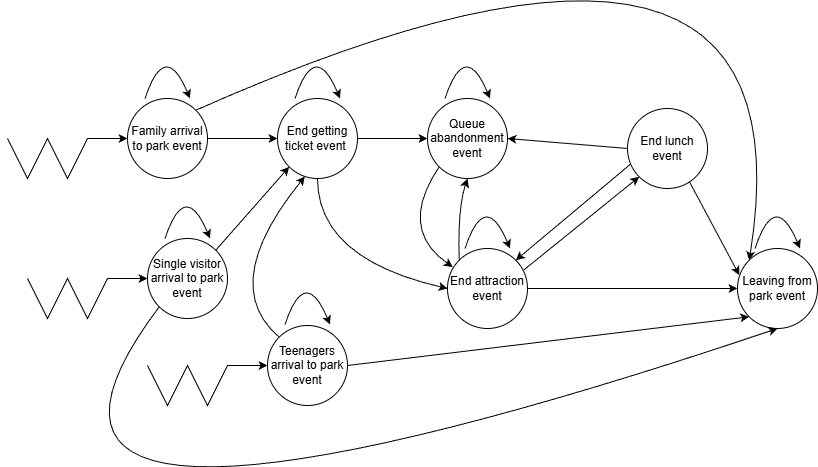
## **:תרשים טיפול - אירוע נטישת תור**
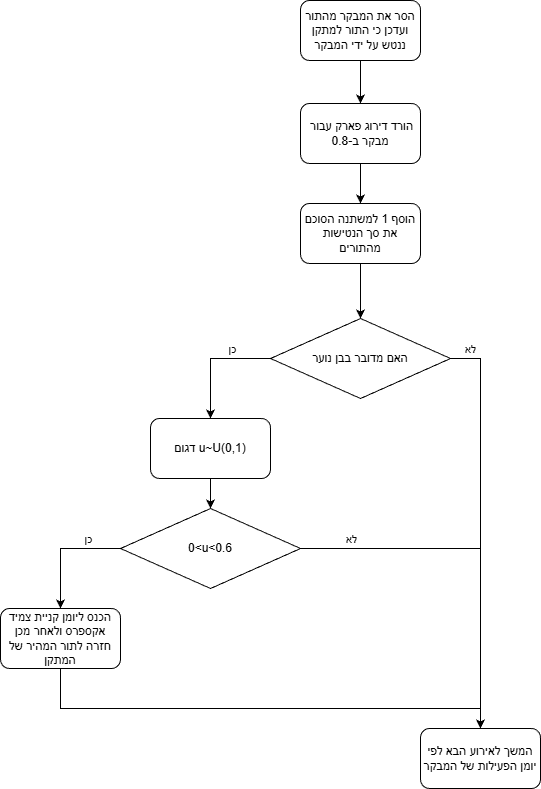
## **:תרשים טיפול - אירוע סיום ארוחת צהריים**
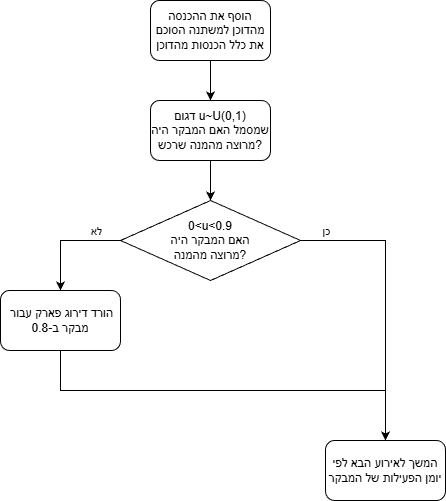
## **:תרשים טיפול - אירוע סיום הגעת מבקר יחיד**
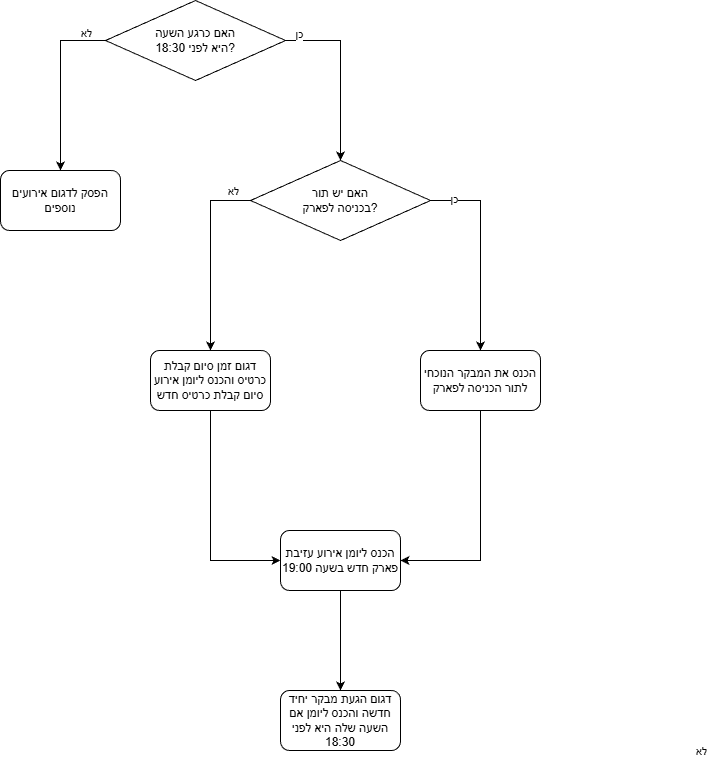


## **בחירת מדדים:**

**הרווח הכולל של הפרק**

הרווח הכולל של הפארק הוא מדד הביצוע המרכזי הבוחן את הצלחתו הכלכלית של המודל. הרווח נגזר ממכירת כרטיסים, רכישה חד-פעמית בדוכני המזון, ורכישת תמונות ביציאה. מאחר שרכישת תמונות מותנית בשביעות הרצון של המבקר, מדד זה משמש כבבואה לרמת ההנאה שהופקה מהביקור.

**זמן המתנה ממוצע בתור**

זמן המתנה ממוצע בתור (כלל-פארקי) מהווה אינדיקציה ליעילות התפעולית ולעומס על תשתיות הפארק. במודל הנוכחי, זמן ההמתנה הוא גורם שמשפיע מאוד על חוויית המשתמש; המתנה ממושכת שוחקת את הנאת המבקר ומורידה את הדירוג הסובייקטיבי שהוא מעניק לפארק, מה שמשפיע ישירות על נכונותו להשקיע ברכישת מזכרות ותמונות בסיום היום.

**אחוז נטישה מתורי האטרקציות**

אחוז נטישה מתורי אטרקציות הוא מדד התנהגותי המזהה כשלים נקודתיים וצווארי בקבוק. נטישה היא "הכרזת אי-אמון" של המבקר במתקן מסוים, והיא משמשת כמשתנה המוריד את דירוג הפארק באופן משמעותי. מעקב אחר אחוז הנטישה מאפשר להבין לא רק כמה זמן אנשים המתינו, אלא באיזה אחוז ההמתנה הפכה לבלתי נסבלת עבורם.

---

השילוב בין המדדים מאפשר לבחון את השרשרת הסיבתית בסימולציה: תפעול, חוויה,  רווח. בעוד שהכנסות מכרטיסים ואוכל הן יציבות יחסית, הרווח ממכירת תמונות הוא "רווח מבוסס רגש" . אם הסימולציה תראה זמני המתנה גבוהים ואחוזי נטישה גדלים, נוכל לצפות לירידה בדירוג הפארק ובהתאמה לירידה ברווח הכולל (למרות שכמות המבקרים לא השתנתה). המודל מאפשר לנו למצוא את "נקודת הקריסה" של החוויה – זו שמעבר לה, העומס כבר לא משתלם כלכלית כי הוא פוגע במכירות הקצה ביציאה.

# Visitiors Classes


In [ ]:
# Visitor Classes
class Visitor:
  def __init__(self, rank, age, group):
    self.rank = 10.0 # initial ranking
    self.group = group
    self.age = age
    self.activity_diary = []

  def add_rank(self, adrenaline_level):
    # scoring formula
    GS = self.group.amount_of_members
    score = (((GS - 1) / 5 )* 0.3) + (((adrenaline_level - 1) / 4) * 0.7)
    self.rank = min(10,self.rank + score)

  def decrease_rank(self, penalty):
    self.rank = max(0, self.rank - penalty)

  def enter_successful(self, activity):
    for act in self.activity_diary:
      if act[0] == activity:
        act[1] = True
        break


class Group:
  def __init__(self, amount_of_members, max_wait_time):
    self.has_express = random.random() < 0.25
    self.amount_of_members = amount_of_members
    self.members = []
    self.pictures_cost = 0
    # Convert max_wait_time to timedelta if it's not already
    if isinstance(max_wait_time, timedelta):
      self.max_wait_time = max_wait_time
    else:
      self.max_wait_time = timedelta(minutes=float(max_wait_time))
    self.decided_on_lunch = False

  def increase_rank(self, adrenaline_level):
    for Visitor in self.members:
        Visitor.add_rank(adrenaline_level)

  def decrease_rank(self, decrease_value):
    for Visitor in self.members:
        Visitor.decrease_rank(decrease_value)

  # Generates the activity diary of the group in the beginning, Forces the inheritors to write this function
  def generate_activity_diary(self):
    pass

  # Returns the next possible activities that the group needs to proceed to, Forces the inheritors to write this function
  def get_candidate_activities(self, last_activity_tried):
    pass

  # Checks if the first 'count' activities have already completed
  def is_phase_finished(self, count):
    return all(act[1] for act in self.members[0].activity_diary[:count])

  def find_min_age(self):
    minAge = self.members[0].age
    for i in range(1, len(self.members)):
      if (self.members[i].age < minAge):
        minAge = self.members[i].age
    return minAge

  def purchase_pictures(self):
    avg_rank = sum(m.rank for m in self.members) / len(self.members)

    # Charge according to average rank
    if avg_rank >= 8.5:
      # 10 photos and a video
      self.pictures_cost = 120
    elif 7.5 <= avg_rank < 8.5:
      # 10 photos
      self.pictures_cost = 100
    elif 6.0 <= avg_rank < 7.5:
      # 1 photo
      self.pictures_cost = 20
    else:
      #Not buying photos
      self.pictures_cost = 0

  def units_for(self, activity):
    # When it's kid's pool, only kids under 4 enter
    if activity == "Kids Pool":
      kidsNum = 0
      for member in self.members:
        if member.age <= 4:
          kidsNum+=1
      return kidsNum

    return self.amount_of_members

  def add_activity_if_not_exists(self, activity_name):
    has_activity = any(activity_name in act for act in self.members[0].activity_diary)
    if not has_activity:
      for member in self.members:
        member.activity_diary.append([activity_name, False])
      return True  # Added successfully
    return False  # Already existed


class SingleVisitor(Group):
  def __init__(self, age = 35):
    super().__init__(amount_of_members=1, max_wait_time=30)

  @staticmethod
  def CreateSingleVisitor():
    new_single_visitor = SingleVisitor()
    # Using reasonable upper bound of 30, choosing continous uniform distribution
    single_visitor_age = Algorithm.sample_continuous_uniform(18, 30)
    single_visitor = Visitor(rank=10, age=single_visitor_age, group=new_single_visitor)
    new_single_visitor.members.append(single_visitor)

    # Addition 1: Generate the activity diary
    new_single_visitor.generate_activity_diary()

    # Addition 2: Return the new single visitor object
    return new_single_visitor

  def generate_activity_diary(self):
    self.members[0].activity_diary = [["Single Water Slide", False], ["Small Tube Slide", False], ["Waves Pool", False],
                                      ["Big Tube Slide", False], ["Lazy River", False], ["Snorkeling Tour", False]]


  def get_candidate_activities(self, last_activity_tried):
    # Dividing the diary to 2 phases - before finishing the rides for ages 12 or more and after it
    phase1 = self.members[0].activity_diary[:3]
    phase2 = self.members[0].activity_diary[3:]

    # phase 1
    if not all(act[1] for act in phase1):
      candidates = [act[0] for act in phase1 if not act[1] and act[0] != last_activity_tried]

    # phase 2
    else:
      candidates = [act[0] for act in phase2 if not act[1] and act[0] != last_activity_tried]

    return candidates

class Family(Group):
  def __init__(self):
    self.split = False
    super().__init__(2 + Algorithm.sample_number_of_children(1,5),15)
    self.split_groups = []
    self.leave_time = datetime(2025, 1, 1) + timedelta(hours=Algorithm.sample_family_leaving_time())
    # Decide if family will split (60% chance)
    self.will_split = random.random() < 0.6


  @staticmethod
  def CreateFamily():
    new_family = Family()
    num_children = new_family.amount_of_members - 2
    # Create 2 parents
    for i in range(2):
      parent_age = 35  # Assuming all parents are 35
      parent = Visitor(rank=10, age=parent_age, group=new_family)
      new_family.members.append(parent)
    # Create children
    for i in range(num_children):
      child_age = Algorithm.sample_continuous_uniform(2, 18)
      child = Visitor(rank=10, age=child_age, group=new_family)
      new_family.members.append(child)




    # generate activity diary for the family
    new_family.generate_activity_diary()

    return new_family


  def generate_activity_diary(self):#including spilt
    # Generate for family only the rides for all ages
    self.members[0].activity_diary = [["Lazy River", False], ["Big Tube Slide", False]]
    random.shuffle(self.members[0].activity_diary)

    # Makes sure all of the family has the same diary
    for i in range(1, len(self.members)):
      self.members[i].activity_diary = copy.deepcopy(self.members[0].activity_diary)

  def generate_final_activity_diary(self):
    if self.split and self.split_groups:
      for group in self.split_groups:
        group.generate_activity_diary()
    else:
      minAge = self.find_min_age()
      if minAge >= 12:
        self.add_activity_if_not_exists("Waves Pool")
        self.add_activity_if_not_exists("Small Tube Slide")
      if minAge >= 14:
        self.add_activity_if_not_exists("Single Water Slide")
      if minAge >= 6:
        self.add_activity_if_not_exists("Snorkeling Tour")
      if minAge <= 4:
        self.add_activity_if_not_exists("Kids Pool")

  def get_candidate_activities(self, last_activity_tried):
    # Phase 1 - before the decision on splitting
    phase1 = self.members[0].activity_diary[:2]

    # We're still on phase 1
    if not all(act[1] for act in phase1):
      candidates = [act[0] for act in phase1 if not act[1] and act[0] != last_activity_tried]

    # We're after the decision on splitting
    else:
      phase2 = self.members[0].activity_diary[2:]
      candidates = [act[0] for act in phase2 if not act[1] and act[0] != last_activity_tried]

    return candidates


  def decide_on_split(self):
    # If already split, return existing split groups
    if self.split:
      return self.split_groups

    if self.will_split:
      self.split = True
      # Separate parents and children
      parents = [m for m in self.members if m.age >= 18]
      children = [m for m in self.members if m.age < 18]

      # Categorize children by age
      young_children = [c for c in children if c.age < 8]  # Must have parent or 12+
      middle_children = [c for c in children if 8 <= c.age < 12]  # Independent
      older_children = [c for c in children if c.age >= 12]  # Can supervise

      # Decide number of groups (2 or 3, equal probability)
      if random.random() < 0.5:
        num_groups = 2
      else:
        num_groups = 3

      if num_groups == 3 and self.can_split_into_three(young_children, older_children, middle_children):
        self.split_groups = self.split_into_three_groups(parents, young_children, middle_children, older_children)

      else:
        self.split_groups = self.split_into_two_groups(parents, young_children, middle_children, older_children)

      # Generates the rest of the activities (after the family splitted)
      self.generate_final_activity_diary()
      return self.split_groups

    else: # Family doesn't split
        # Generates the rest of the activities (after the family decided not to split)
        self.generate_final_activity_diary()
        return [self]

  def distribute_children(self, children, num_groups, start_index=0):
    groups = [[] for _ in range(num_groups)]

    for i, child in enumerate(children[start_index:], start=start_index):
      group_index = i % num_groups
      groups[group_index].append(child)

    return groups

  # Split family to 2 groups
  def split_into_two_groups(self, parents, young, middle, older):

    # Start with parents
    group1_members = [parents[0]]
    group2_members = [parents[1]]

    # Distribute young children
    if young:
      # Distribute young children half and half
      young_groups = self.distribute_children(young, num_groups=2)
      group1_members.extend(young_groups[0])
      group2_members.extend(young_groups[1])

    # Distribute older children
    if older:
      older_groups = self.distribute_children(older, num_groups=2)
      group1_members.extend(older_groups[0])
      group2_members.extend(older_groups[1])

    # Distribute middle children
    middle_groups = self.distribute_children(middle, num_groups=2)
    group1_members.extend(middle_groups[0])
    group2_members.extend(middle_groups[1])

    # Create SplitedFamily objects
    return self.create_splitted_family([group1_members, group2_members])

  # Split family into 3 groups
  def split_into_three_groups(self, parents, young, middle, older):

    group1_members = [parents[0]]
    group2_members = [parents[1]]
    group3_members = [] # Group 3 is led by an older/middle child

    # Track remaining older and middle children
    remaining_older = older
    remaining_middle = middle


    if older:
      # Priority 1: An older child leads
      group3_members = [older[0]]
      remaining_older = older[1:]
    elif middle:
      # Priority 2: A middle child leads (if no older kids exist)
      group3_members = [middle[0]]
      remaining_middle = middle[1:]

    # Distribute young children
    if young:
      young_groups = self.distribute_children(young, num_groups=3)
      group1_members.extend(young_groups[0])
      group2_members.extend(young_groups[1])
      group3_members.extend(young_groups[2])

    # Distribute remaining older children
    if remaining_older:
      older_groups = self.distribute_children(remaining_older, num_groups=3)
      group1_members.extend(older_groups[0])
      group2_members.extend(older_groups[1])
      group3_members.extend(older_groups[2])

    # Distribute middle children
    if remaining_middle:
      middle_groups = self.distribute_children(middle, num_groups=3)
      group1_members.extend(middle_groups[0])
      group2_members.extend(middle_groups[1])
      group3_members.extend(middle_groups[2])

    # Create SplitedFamily objects
    return self.create_splitted_family([group1_members, group2_members, group3_members])

  # Check if a family can split into 3 according to instructions
  def can_split_into_three(self, young, older, middle):
    return len(older) + len(middle) > 0


  def create_splitted_family(self, sub_groups):
    created = []
    # Create Splits
    for group in sub_groups:
      split_group = SplittedFamily(len(group), group, self)
      created.append(split_group)
    self.split_groups.extend(created)
    return self.split_groups


class SplittedFamily(Group):
  def __init__(self, amount_of_members, members, original_family):
    super().__init__(amount_of_members,15)
    self.members = list(members)
    self.original_family = original_family
    self.has_express = original_family.has_express
    self.leave_time = original_family.leave_time

    # Update group reference for each member
    for member in self.members:
      member.group = self

  def generate_activity_diary(self):
    minAge = self.find_min_age()
    if minAge >= 12:
      self.add_activity_if_not_exists("Waves Pool")
      self.add_activity_if_not_exists("Small Tube Slide")
    if minAge >= 14:
      self.add_activity_if_not_exists("Single Water Slide")
    if minAge >= 6:
      self.add_activity_if_not_exists("Snorkeling Tour")
    if minAge <= 4:
      self.add_activity_if_not_exists("Kids Pool")

  def get_candidate_activities(self, last_activity_tried):

    # Phase 1 - before the decision on splitting
    phase1 = self.members[0].activity_diary[:2]

    # We're still on phase 1
    if not all(act[1] for act in phase1):
      return [act[0] for act in phase1 if not act[1] and act[0] != last_activity_tried]

    # We're after the decision on splitting
    phase2 = self.members[0].activity_diary[2:]
    return [act[0] for act in phase2 if not act[1] and act[0] != last_activity_tried]



class Teenagers(Group):
  def __init__(self):
    super().__init__(Algorithm.sample_number_of_teenagers(), 20)
    self.last_abandoned_activity = None

  @staticmethod
  def CreateTeenagers():
      new_teenage_group = Teenagers()
      # Create teenager members
      for i in range(new_teenage_group.amount_of_members):
          # age uniform continuous [14, 17]
          teen_age = Algorithm.sample_continuous_uniform(14, 17)
          teen = Visitor(rank=10, age=teen_age, group=new_teenage_group)
          new_teenage_group.members.append(teen)

    # Generate the activity diary
      new_teenage_group.generate_activity_diary()

    # Return the new group
      return new_teenage_group

  def buy_express(self, simulation):
    self.has_express = True
    simulation.park.special_express_revenue += self.amount_of_members * 50

  def generate_activity_diary(self):
    # Generate for teenagers only the rides with 3+ adrenaline
    self.members[0].activity_diary = [["Single Water Slide", False], ["Small Tube Slide", False], ["Waves Pool", False], ["Snorkeling Tour", False]]
    random.shuffle(self.members[0].activity_diary)

    # Makes sure all the teenagers have the same diary
    for i in range(1, len(self.members)):
      self.members[i].activity_diary = copy.deepcopy(self.members[0].activity_diary)

  def get_candidate_activities(self, last_activity_tried):
    # If we have express we don't care about the last activity
    if self.has_express:
      return [act[0] for act in self.members[0].activity_diary if not act[1]]

    # If we don't have express we care about the last activity
    return [act[0] for act in self.members[0].activity_diary if not act[1] and act[0] != last_activity_tried]



#Facility Classes

In [ ]:
class Park:
  def __init__(self):
    self.visitor_groups = []
    self.current_visitor_group = []
    self.special_express_revenue = 0
    self.avg_rank = 0
    self.facilities = {} # a dictionary for all the park's facilities
    self.queues = {} # a dictionary for all the park's queues
    self.opening_hour = datetime(2025, 1, 1, 9, 0)
    self.closing_hour = datetime(2025, 1, 1, 19, 0)
    self.create_rides_and_food_stands()

  def create_rides_and_food_stands(self):
      # Setting all the park's queues
    self.queues["Park Entrance"] = Queue("Park Entrance")
    self.queues["Lazy River"] = Queue("Lazy River")
    self.queues["Single Water Slide"] = Queue("Single Water Slide")
    self.queues["Big Tube Slide"] = Queue("Big Tube Slide")
    self.queues["Small Tube Slide"] = Queue("Small Tube Slide")
    self.queues["Waves Pool"] = Queue("Waves Pool")
    self.queues["Kids Pool"] = Queue("Kids Pool")
    self.queues["Snorkeling Tour"] = Queue("Snorkeling Tour")
    # Setting all the park's facilities
    self.facilities["Park Entrance"] = ParkEntrance()
    self.facilities["Lazy River"] = LazyRiverAttraction(self.queues["Lazy River"])
    self.facilities["Single Water Slide"] = SingleWaterSlideAttraction(self.queues["Single Water Slide"])
    self.facilities["Big Tube Slide"] = BigTubeSlideAttraction(self.queues["Big Tube Slide"])
    self.facilities["Small Tube Slide"] = SmallTubeSlideAttraction(self.queues["Small Tube Slide"])
    self.facilities["Waves Pool"] = WavesPoolAttraction(self.queues["Waves Pool"])
    self.facilities["Kids Pool"] = KidsPoolAttraction(self.queues["Kids Pool"])
    self.facilities["Snorkeling Tour"] = SnorkelingTourAttraction(self.opening_hour, self.queues["Snorkeling Tour"])
    self.facilities["Pizza stand"] = PizzaFoodStand()
    self.facilities["Hamburger stand"] = HamburgerFoodStand()
    self.facilities["Salad stand"] = SaladFoodStand()


  def cacl_amount_of_visitors(self):
    amount_of_visitors = 0
    for vg in self.visitor_groups:
      for m in vg.members:
        amount_of_visitors += 1
    return amount_of_visitors

  def calc_avg_ranking(self):
    if not self.visitor_groups:
      self.avg_rank = 0
      return 0
    # Calculate the rating by summing all the rates and dividing by number of visitors
    total_rank = 0
    for vg in self.visitor_groups:
      for m in vg.members:
        total_rank += m.rank
    self.avg_rank = total_rank / self.cacl_amount_of_visitors()
    return self.avg_rank

  def calc_total_revenue(self):
    return (self.special_express_revenue +
        self.facilities["Park Entrance"].total_revenue +
        self.facilities["Pizza stand"].total_revenue +
        self.facilities["Hamburger stand"].total_revenue +
        self.facilities["Salad stand"].total_revenue +
        sum(g.pictures_cost for g in self.visitor_groups))

class Facility:
  def __init__(self, name, num_servers, capacity_per_server):
    self.name = name
    self.available_servers = num_servers
    self.capacity_per_server = capacity_per_server

  def is_idle(self):
    return self.available_servers > 0

  def assign_server(self):
    self.available_servers -= 1

  def release_server(self):
    self.available_servers += 1

class ParkEntrance(Facility):
  def __init__(self, num_servers=3):
    super().__init__("Park Entrance", num_servers=num_servers, capacity_per_server=1)
    self.total_revenue = 0

  def calculate_and_charge(self, group):
  # Calculate price
    group_total_cost = 0
    for member in group.members:

      # Pricing by age
      if member.age >= 14:
        ticket_price = 150
      else:
        ticket_price = 75

      # Express addition for every ticket
      if group.has_express:
        ticket_price += 50

      group_total_cost += ticket_price

    self.total_revenue += group_total_cost



# Rides Classes

In [ ]:
class Attraction(Facility):
    def __init__(self, name, adrenalinLevel, minAge, available_servers, rideCapacity, queue):
      super().__init__(name, available_servers, rideCapacity)
      self.rideCapacity = rideCapacity
      self.adrenalinLevel = adrenalinLevel
      self.minAge = minAge
      self.queue = queue

    def enter_ride(self,session, units_to_enter, time = datetime(2025,1,1,9,0), guide_num = None):
      pass

    def exit_ride(self,session, units_finished):
      pass

    def get_free_capacity(self, current_time) -> int:
      #get specific capacity
      pass

    def get_ride_time(self):
      pass

    def has_free_capacity(self, group = None, end_time = datetime(2025,1,1,19,0), start_time = datetime(2025,1,1,9,0)) -> bool:
      # At least one free spot for the given group and/or at least one free server
      pass

    def can_enter_immediately(self, group, current_time=None):
      result = len(self.queue.queue) == 0 and self.has_free_capacity(group, current_time, current_time)
      return result

    def get_priority_session(self, simulation):
      # Find the relevant session
      activity_name = self.name
      for (group, act_name), session in simulation.sessions.items():
        if act_name == activity_name:
            return session
      return None


    def find_tube(self, tubes, tube_id):
      for tube in tubes:
          if tube["tube_id"] == tube_id:
              return tube
      return None

    def add_session_to_tube(self, tubes, tube_id, session):
      tube = self.find_tube(tubes, tube_id)
      if tube is None:
          tube = {"tube_id": tube_id, "sessions": []}
          tubes.append(tube)
      tube["sessions"].append(session)

    def remove_tube(self, tubes, tube_id):
      for i, tube in enumerate(tubes):
          if tube["tube_id"] == tube_id:
              tubes.pop(i)
              return True
      return False

    def remove_tube_by_session(self, tubes, session):
      for i, tube in enumerate(tubes):
          if session in tube.get("sessions", []):
              tubes.pop(i)
              return True
      return False


    def count_tubes(self, tubes):
      return len(tubes)
    def has_tube(self, tubes, tube_id):
      return self.find_tube(tubes, tube_id) is not None


class LazyRiverAttraction(Attraction):
    def __init__(self, queue):
      super().__init__("Lazy River", adrenalinLevel=1, minAge=0, available_servers=60, rideCapacity=2, queue=queue)
      self.tubes=[] # Current tubes by enter time

    def enter_ride(self,session,units_to_enter, time = datetime(2025,1,1,9,0), guide_num = None):
          # Generate a unique tube_id based on the counter
          tube_id = len(self.tubes) + 1
          self.add_session_to_tube(self.tubes, tube_id, session)

    def exit_ride(self,session, units_finished):
        self.remove_tube_by_session(self.tubes, session)


    def get_ride_time(self):
      return Algorithm.sample_continuous_uniform(20,30)

    def get_free_capacity(self, current_time) -> int:
      if len(self.tubes) < self.available_servers:
        return self.rideCapacity
      return 0

    def has_free_capacity(self, group=None, end_time=datetime(2025,1,1,19,0), start_time=datetime(2025,1,1,9,0)) -> bool:
      has_capacity = len(self.tubes) < self.available_servers
      return has_capacity, 0

class SingleWaterSlideAttraction(Attraction):
  def __init__(self, queue):
    super().__init__("Single Water Slide", adrenalinLevel=5, minAge=14, available_servers=2, rideCapacity=1, queue=queue)
    self.slide_ready_at = [datetime(2025, 1, 1, 9, 0), datetime(2025, 1, 1, 9, 0)]
    self.slide_occupancy = [0, 0]
    self.ride_time_minutes = 3.0 # Takes exactly 3 minutes
    self.safety_gap = timedelta(seconds=30) # Safety gap is exactly 30 seconds

  def find_available_slide(self, current_time):
    # Find a slide which more than 30 seconds has passed since the last visitor entered & that it's occupancy is less than 6
    for i in range(len(self.slide_ready_at)):
      if current_time >= self.slide_ready_at[i] and self.slide_occupancy[i] < 6:
        return i
    return None

  def enter_ride(self, session, units_to_enter, time, slide_idx):
    # Handle the slide entry
    if slide_idx is not None:
      # Block the slide for the next 30 seconds
      self.slide_ready_at[slide_idx] = time + self.safety_gap
      self.slide_occupancy[slide_idx] += 1
      # Keeping the slide index in the session so we would know in the exit which slide is the assigned one
      session.assigned_slide = slide_idx

  def exit_ride(self, session, units_finished):
    # Releasing the current slide
    if hasattr(session, 'assigned_slide'):
      idx = session.assigned_slide
      self.slide_occupancy[idx] = max(0, self.slide_occupancy[idx] - 1)

  def get_free_capacity(self, current_time) -> int:
    # Returns the amount of slides available now
    ready_slides = 0
    for i in range(len(self.slide_ready_at)):
      if current_time >= self.slide_ready_at[i] and self.slide_occupancy[i] < 6:
        ready_slides += 1
    return ready_slides

  def has_free_capacity(self, group, end_time, start_time):
    # Return True if there is at least 1 ready slide, and the slide index
    slide_idx = self.find_available_slide(start_time)
    if slide_idx is not None:
      return True, slide_idx
    return False, None

  def get_ride_time(self):
    return self.ride_time_minutes

class BigTubeSlideAttraction(Attraction):
    def __init__(self,queue):
      if GLOBAL_IS_ALT_1:
        capacity = 10
      else:
        capacity = 8
      super().__init__("Big Tube Slide", adrenalinLevel=2, minAge=0, available_servers=1, rideCapacity=capacity, queue=queue)
      self.max_tubes = 1
      self.tubes=[]

    def get_ride_time(self):
      return Algorithm.sample_normal(4.800664, 1.823101)

    def enter_ride(self,session,units_to_enter, time = datetime(2025,1,1,9,0), guide_num = None):
        self.add_session_to_tube(self.tubes, time, session)

    def exit_ride(self,session, units_finished):
          self.remove_tube_by_session(self.tubes, session)

    def get_free_capacity(self, current_time) -> int:
      return self.rideCapacity

    def has_free_capacity(self, group=None, end_time=datetime(2025,1,1,19,0), start_time=datetime(2025,1,1,9,0)) -> bool:
      return self.count_tubes(self.tubes) < self.max_tubes


class SmallTubeSlideAttraction(Attraction):
    def __init__(self,queue):
      super().__init__("Small Tube Slide", adrenalinLevel=4, minAge=12, available_servers=1, rideCapacity=3, queue=queue)
      self.max_tubes = 1
      self.tubes = []

    def get_ride_time(self):
      return Algorithm.sample_exponential(2.107060)

    def enter_ride(self,session,units_to_enter, time = datetime(2025,1,1,9,0), guide_num = None):
        self.add_session_to_tube(self.tubes, time, session)


    def exit_ride(self,session, units_finished):
          self.remove_tube_by_session(self.tubes, session)

    def get_free_capacity(self, current_time) -> int:
      return self.rideCapacity

    def has_free_capacity(self, group=None, end_time=datetime(2025,1,1,19,0), start_time=datetime(2025,1,1,9,0)) -> bool:
      return self.count_tubes(self.tubes) < self.max_tubes


class WavesPoolAttraction(Attraction):
    def __init__(self,queue):
      if GLOBAL_IS_ALT_2:
        capacity = 120
      else:
        capacity = 80
      super().__init__("Waves Pool", adrenalinLevel=3, minAge=12, available_servers=1, rideCapacity=80, queue=queue)
      self.occupied_spots = 0

    def enter_ride(self, session, units_to_enter, time, guide_num=None):
      self.occupied_spots += units_to_enter

    def exit_ride(self,session, units_finished):
      self.occupied_spots -= units_finished

    def get_ride_time(self):
      return Algorithm.generate_wavepool_time()

    def get_free_capacity(self, current_time) -> int:
        return self.rideCapacity-self.occupied_spots

    def check_spots(self, guest_size):
        if self.rideCapacity - self.occupied_spots >= guest_size:
            return True
        return False

    def has_free_capacity(self, group=None, end_time=datetime(2025,1,1,19,0), start_time=datetime(2025,1,1,9,0)) -> bool:
      return self.occupied_spots < self.rideCapacity



class KidsPoolAttraction(Attraction):
  def __init__(self,queue):
      super().__init__("Kids Pool", adrenalinLevel=1, minAge=0, available_servers=1, rideCapacity=30, queue=queue)
      self.maxAge = 4
      self.occupied_spots=0

  def get_ride_time(self):
    return Algorithm.generate_kids_pool_time()

  def enter_ride(self, session, units_to_enter, time, guide_num=None):
    self.occupied_spots += units_to_enter

  def exit_ride(self,session, units_finished):
    self.occupied_spots -= units_finished


  def get_free_capacity(self, current_time) -> int:
      return self.rideCapacity-self.occupied_spots

  def check_spots(self, guest_size):
      if self.rideCapacity - self.occupied_spots >= guest_size:
          return True
      return False

  def has_free_capacity(self, group=None, end_time=datetime(2025,1,1,19,0), start_time=datetime(2025,1,1,9,0)) -> bool:
    return self.occupied_spots < self.rideCapacity



class SnorkelingTourAttraction(Attraction):
  def __init__(self, open_time: datetime, queue):
    super().__init__("Snorkeling Tour", adrenalinLevel=3, minAge=6, available_servers=2, rideCapacity=30 , queue=queue)
    self.guide_available_at = [open_time, open_time]
    self.collecting_size = [0, 0]
    self.guide_break = timedelta(minutes=30)
    self.lunch_start = datetime(2025, 1, 1, 13, 0, 0)
    self.lunch_end = datetime(2025, 1, 1, 14, 0, 0)

  def get_ride_time(self):
    return Algorithm.sample_normal(30, 10)

  def tour_conflicts_with_lunch(self,start,end):
    # Check if tour overlaps with lunch period at all
      return not (end <= self.lunch_start or start >= self.lunch_end)

  def find_free_guide(self, group, start_time):
    size = len(group.members)
    for gid in (0, 1):
      # Check if there is an available guide with enough space left
      if start_time >= self.guide_available_at[gid] and self.collecting_size[gid] + size <= self.rideCapacity:
        return gid
    return None

  def has_free_capacity(self, group, end_time, start_time) :
    # Check if there is an available guide with enough space left
    guide = self.find_free_guide(group, start_time)
    if guide != None:
      # Check time of tour is valid
      if self.tour_conflicts_with_lunch(start_time, end_time):
        # do not start now, delay guide availability to 14:00
        self.guide_available_at[guide] = self.lunch_end
        return False, None
      else:
        # Schedule tour starting now
        self.guide_available_at[guide] = end_time + self.guide_break
        return True, guide
    return False, None

  def can_enter_immediately(self, group, current_time=None):
    if current_time is None:
        current_time = datetime(2025, 1, 1, 9, 0)
    guide = self.find_free_guide(group, current_time)
    return len(self.queue.queue) == 0 and guide != None, guide

  def get_free_capacity(self, current_time):
    return self.rideCapacity

  def enter_ride(self, session, size, time, guide_num):
    self.collecting_size[guide_num] += size

  def exit_ride(self, session, units_finished):
    # Find which guide was handling this session and reduce their collecting_size
    # Since we don't track guide assignment in session, we need to find the guide
    # This is a simple implementation - in practice you'd want to track guide assignments
    for gid in range(len(self.collecting_size)):
      if self.collecting_size[gid] >= units_finished:
        self.collecting_size[gid] -= units_finished
        break

#Foodstand Classes

In [ ]:
class FoodStand:
  def __init__(self, name):
    self.name = name
    if GLOBAL_IS_ALT_1:
      self.bad_meal_prob = 0.03
    else:
      self.bad_meal_prob = 0.1
    self.total_revenue = 0
    self.opening_hour = datetime(2025, 1, 1, 13, 0)
    self.closing_hour = datetime(2025, 1, 1, 15, 0)

  @staticmethod
  def decide_on_stand():
    rand = random.random()
    # Hamburger case
    if rand < 3/8:
      return "Hamburger stand"
    # Pizza case
    elif 3/8 < rand < 5/8:
      return "Pizza stand"
    # Salad case
    else:
      return "Salad stand"


  def calculate_service_and_eating(self):
    # Sample service time from normal distribution
    service_time = Algorithm.sample_normal(5, 1.5)

    # Sample eating time from continuous uniform distribution
    eating_time = Algorithm.sample_continuous_uniform(15, 35)

    return service_time + eating_time

  def get_total_duration(self, group):
    # Calculate total lunch duration
    pass

  def process_meal(self, group):
    # Calculate income and adds ranking

    # Calculate income according to type of group and stand
    income = self.calculate_income(group)
    self.total_revenue += income

    # Bad meal logic
    if random.random() < self.bad_meal_prob:
        group.decrease_rank(0.8)

  def calculate_income(self, group):
    # Calculates the income
    pass

class PizzaFoodStand(FoodStand):
  def __init__(self):
    super().__init__("Pizza Stand")
    self.prices = {"Personal": 40, "Group": 100}

  def calculate_income(self, group):
    if isinstance(group, Family) or isinstance (group, Teenagers):
        return self.prices["Group"]
    return self.prices["Personal"]

  def get_total_duration(self,group):
    prep_time=Algorithm.sample_continuous_uniform(4, 6)
    return prep_time + self.calculate_service_and_eating()

class HamburgerFoodStand(FoodStand):
  def __init__(self):
    super().__init__("Hamburger Stand")

  def get_total_duration(self,group):
    prep_per_person=Algorithm.sample_continuous_uniform(3, 4)
    prep_time = len(group.members) * prep_per_person
    return prep_time + self.calculate_service_and_eating()

  def calculate_income(self, group):
    return 100 * len(group.members)

class SaladFoodStand(FoodStand):
  def __init__(self):
    super().__init__("Salad Stand")

  def calculate_income(self, group):
    return 65 * len(group.members)

  def get_total_duration(self,group):
    prep_per_person=Algorithm.sample_continuous_uniform(3, 7)
    prep_time = len(group.members) * prep_per_person
    return prep_time + self.calculate_service_and_eating()

# Queue Classes

In [ ]:
class Queue:
    def __init__(self, facility_name: str):
        self.facility_name: str = facility_name
        self.queue: List[Any] = []

        # All metrics are in MINUTES (float)
        self.waiting_times: List[float] = []          # per-unit served wait (minutes)
        self.renege_waiting_times: List[float] = []   # per-unit reneged wait (minutes)

        self.arrivals_units: int = 0   # people who arrived to this queue (incl. immediate entry)
        self.served_units: int = 0     # people who actually entered service (sum of batches)
        self.reneged_units: int = 0    # people who reneged

        # Weighted queue length is in PERSON-MINUTES (float)
        self.last_change_time: Optional[datetime] = None
        self.weighted_queue_length_sum: float = 0.0

    # ------------------------------------------------------------
    # Park entrance buffer
    # ------------------------------------------------------------
    def add_to_park_entrance(self, group: Any, current_time: datetime) -> None:
      self.arrivals_units += int(getattr(group, "amount_of_members", 1))
      group.entrance_entry_time = current_time
      self.queue.append(group)

    def pop_from_park_entrance(self, current_time: datetime) -> Optional[Any]:
      if not self.queue:
          return None

      group = self.queue.pop(0)

      units = getattr(group, "amount_of_members", 1)  # תמיד להגדיר
      entry_time = getattr(group, "entrance_entry_time", None)

      if entry_time is not None:
          waiting_minutes = (current_time - entry_time).total_seconds() / 60.0
          self.waiting_times.extend([waiting_minutes] * int(units))

      self.served_units += int(units)
      return group



    # ------------------------------------------------------------
    # Core queue API (for EndAttractionEvent)
    # ------------------------------------------------------------
    def is_empty(self) -> bool:
        return len(self.queue) == 0

    def __len__(self) -> int:
        return len(self.queue)

    def peek(self) -> Optional[Any]:
        if not self.queue:
            return None
        return self.queue[0]

    def get(self, index: int) -> Any:
        return self.queue[index]

    def add_group(self, group: Any, current_time: datetime) -> None:
      if isinstance (group, Teenagers):
        group.time_entered_to_abandoned_activity = current_time
      # Update weighted length before any structural change
      self._update_weighted_length(current_time)
      # Timestamp used for waiting/renege stats
      group.entry_time = current_time
      # Express insertion: after all existing express groups (FIFO within express)
      if getattr(group, "has_express", False):
          insert_pos = 0
          for i, g in enumerate(self.queue):
              if getattr(g, "has_express", False):
                  insert_pos = i + 1
              else:
                  break
          self.queue.insert(insert_pos, group)
      else:
          self.queue.append(group)

    def pop_next_group(self, current_time: datetime) -> Optional[Any]:
        # Pop FIFO head (express already ordered by add_group)
        if not self.queue:
            return None

        self._update_weighted_length(current_time)

        group = self.queue.pop(0)
        if isinstance (group, Teenagers) and group.last_abandoned_activity == self.facility_name and not group.has_express:
            self.teenagers_reduce_rank(group, current_time)

        return group

    def record_wait_for_units(self, group: Any, units: int, current_time: datetime) -> None:
      if units <= 0:
          return
      entry_time = getattr(group, "entry_time", None)
      if entry_time is None:
          return
      waiting_minutes = (current_time - entry_time).total_seconds() / 60.0
      self.waiting_times.extend([waiting_minutes] * int(units))
      self.served_units += int(units)


    def pop_first_group_of_size(self, size: int, current_time: datetime) -> Optional[Any]:
        # scan from front and pop the FIRST group with exact match (amount_of_members == size)
        if size <= 0 or not self.queue:
            return None

        for i, group in enumerate(self.queue):
            if getattr(group, "amount_of_members", None) == size:
                self._update_weighted_length(current_time)
                popped = self.queue.pop(i)
                if isinstance (popped, Teenagers) and popped.last_abandoned_activity == self.facility_name and not popped.has_express:
                  self.teenagers_reduce_rank(popped, current_time)
                return popped

        return None


    def teenagers_reduce_rank(self, group, current_time):
      time_waited = current_time - group.time_entered_to_abandoned_activity
      amount_of_max_waits = time_waited // group.max_wait_time
      for _ in range(int(amount_of_max_waits)):
          group.decrease_rank(0.8)


    def remove_group_on_renege(self, group: Any, current_time: datetime) -> bool:
      # Called by external QueueAbandonmentEvent (renege)
      if group not in self.queue:
          return False

      # structural change -> update person-minutes
      self._update_weighted_length(current_time)

      entry_time = getattr(group, "entry_time", None)
      if entry_time is not None:
          renege_wait_minutes = (current_time - entry_time).total_seconds() / 60.0

          # how many "units" this group represents for THIS facility
          try:
              if hasattr(group, "units_for") and callable(getattr(group, "units_for")):
                  units = int(group.units_for(self.facility_name))
              else:
                  units = int(getattr(group, "amount_of_members", 1))
          except Exception:
              units = int(getattr(group, "amount_of_members", 1))

          # record per-unit reneging wait (so averages are per person)
          self.renege_waiting_times.extend([renege_wait_minutes] * units)
          self.reneged_units += units

      # remove from queue
      self.queue.remove(group)
      return True


    # ------------------------------------------------------------
    # Internal helpers
    # ------------------------------------------------------------
    def _record_waiting_time(self, group: Any, current_time: datetime) -> None:
        entry_time = getattr(group, "entry_time", None)
        if entry_time is None:
            return
        waiting_minutes = (current_time - entry_time).total_seconds() / 60.0
        self.waiting_times.append(waiting_minutes)
    def _current_queue_people(self) -> int:
      total = 0
      for group in self.queue:
          # Same logic as waiting-time weighting
          if hasattr(group, "units_for") and callable(getattr(group, "units_for")):
              try:
                  total += int(group.units_for(self.facility_name))
                  continue
              except Exception:
                  pass

          if hasattr(group, "amount_of_members"):
              total += int(group.amount_of_members)
          else:
              total += 1

      return total

    def _update_weighted_length(self, current_time: datetime) -> None:
        # Accumulate person-minutes since last structural change
        if self.last_change_time is None:
            self.last_change_time = current_time
            return

        duration_minutes = (current_time - self.last_change_time).total_seconds() / 60.0
        if duration_minutes < 0:
            duration_minutes = 0.0

        people_in_queue = self._current_queue_people()
        self.weighted_queue_length_sum += people_in_queue * duration_minutes
        self.last_change_time = current_time

    def exist_group_of_size_or_smaller(self, capacity: int, current_time: datetime) -> bool:
      if capacity <= 0 or not self.queue:
          return False

      for g in self.queue:
          try:
              units = g.units_for(self.facility_name) if hasattr(g, "units_for") else getattr(g, "amount_of_members", 1)
          except Exception:
              units = getattr(g, "amount_of_members", 1)

          if units <= capacity:
              return True

      return False


    def choose_next_group(self, capacity: int, current_time: datetime):
        # Pops FIRST group in queue whose units_for(facility) <= capacity (FIFO)
        if capacity <= 0 or not self.queue:
            return None

        for i, g in enumerate(self.queue):
            try:
                units = g.units_for(self.facility_name) if hasattr(g, "units_for") else getattr(g, "amount_of_members", 1)
            except Exception:
                units = getattr(g, "amount_of_members", 1)

            if units <= capacity:
                # structural change -> update weighted length
                self._update_weighted_length(current_time)

                chosen = self.queue.pop(i)

                # apply teenagers rank reduction logic if relevant (same as in pop_next_group)
                if isinstance(chosen, Teenagers) and getattr(chosen, "last_abandoned_activity", None) == self.facility_name and not getattr(chosen, "has_express", False):
                    self.teenagers_reduce_rank(chosen, current_time)

                return chosen

        return None



#Event Classes

In [ ]:
class Event:
  def __init__(self, time):
    self.time = time

  def __lt__(self, other):
    return self.time < other.time  # Ensure the heap sorts by time

  def handle(self, simulation):
    pass

class SingleVisitorArrivalEvent(Event):
  def __init__(self, time, group):
    super().__init__(time)
    self.group = group

  def handle(self, simulation):
    # Handling the current arrival
    if self.time <= datetime(2025, 1, 1, 18, 30):
      # Add to queue
      simulation.park.queues["Park Entrance"].add_to_park_entrance(self.group, self.time)
      # Check for free servers
      simulation.try_start_entrance_service(self.time)

      simulation.schedule_event(LeavingEvent(datetime(2025, 1, 1, 19, 00), self.group))

    # Sampling next arrival
    if GLOBAL_IS_ALT_2:
      currrent_lambda = 3
    else:
      currrent_lambda = 1.5
    time_until_next_arrival = Algorithm.sample_exponential(currrent_lambda)
    next_arrival_time = self.time + timedelta(minutes=time_until_next_arrival)

    group = SingleVisitor.CreateSingleVisitor()
    if next_arrival_time.time() <= datetime(2025, 1, 1, 18, 30).time():
        simulation.schedule_event(SingleVisitorArrivalEvent(next_arrival_time, group))


class FamilyArrivalEvent(Event):
  def __init__(self, time, group):
      super().__init__(time)
      self.group = group

  def handle(self, simulation):
    # Handling the current arrival
    if datetime(2025, 1, 1, 9, 00) <= self.time <= datetime(2025, 1, 1, 12, 00):
      # Add to queue first (Buffer)
      simulation.park.queues["Park Entrance"].add_to_park_entrance(self.group, self.time)
      # Check if any of the 3 servers are free
      simulation.try_start_entrance_service(self.time)

      # Creating a leaving event at family's leaving time
      simulation.schedule_event(LeavingEvent(self.group.leave_time, self.group))

    # 1.5 a minute
    time_until_next_arrival = Algorithm.sample_exponential(1.5)
    next_arrival_time = self.time + timedelta(minutes=time_until_next_arrival)

    # Taking care of the next arrival event creation
    group = Family.CreateFamily()
    if next_arrival_time.time() <= datetime(2025, 1, 1, 12, 00).time():
        simulation.schedule_event(FamilyArrivalEvent(next_arrival_time, group))


class TeenagersArrivalEvent(Event):
  def __init__(self, time, group):
    super().__init__(time)
    self.group = group

  def handle(self, simulation):
    # Handling the current arrival
    if datetime(2025, 1, 1, 10, 00) <= self.time <= datetime(2025, 1, 1, 16, 00):
      # Add to queue first (Buffer)
      simulation.park.queues["Park Entrance"].add_to_park_entrance(self.group, self.time)
      # Check if any of the 3 servers are free
      simulation.try_start_entrance_service(self.time)

      # Creating a leaving event at 19:00
      simulation.schedule_event(LeavingEvent(datetime(2025, 1, 1, 19, 00), self.group))

    # 500 groups in a 360 minutes is a lambda of 25/18
    time_until_next_arrival = Algorithm.sample_exponential(25/18)
    next_arrival_time = self.time + timedelta(minutes=time_until_next_arrival)

    # Taking care of the next arrival event creation
    group = Teenagers.CreateTeenagers()
    if next_arrival_time.time() <= datetime(2025, 1, 1, 16, 00).time():
        simulation.schedule_event(TeenagersArrivalEvent(next_arrival_time, group))

class EndGettingTicketEvent(Event):
  def __init__(self, time, group):
    super().__init__(time)
    self.group = group

  def handle(self, simulation):
    # Reference the facility as requested
    entrance_facility = simulation.park.facilities["Park Entrance"]

    # 1. Marking the group as visitors in the park
    simulation.park.visitor_groups.append(self.group)
    simulation.park.current_visitor_group.append(self.group)

    # 2. Charging the group for the tickets and bracelets
    entrance_facility.calculate_and_charge(self.group)

    # 3. RELEASE the server (this is what makes the 3-server logic work)
    # This increments available_servers back up
    entrance_facility.release_server()

    # 4. Check if the next group in the queue can start now that a server is free
    simulation.try_start_entrance_service(self.time)

    # 5. Routing the group to their first attraction
    simulation.route_group_to_next(self.group, self.time)

class EndAttractionEvent(Event):
  def __init__(self, time, group, attraction, units_finished):
    super().__init__(time)
    self.group = group
    self.attraction = attraction
    self.units_finished = units_finished

  def handle(self, simulation):



    # Update the group that just finished
    session_key = (self.group, self.attraction.name)
    session = simulation.sessions.get(session_key)

    # Update session
    if session:
      session.record_exit(self.units_finished)
      is_group_completely_done = session.is_finished()
      # Update the attraction that the units finished
      self.attraction.exit_ride(session,self.units_finished)
    else:
      # In case of attractions with no splitting groups
      is_group_completely_done = True
      # Update the attraction that the units finished
      self.attraction.exit_ride(self.group,self.units_finished)

    # Handle the next visitor in queue of the same attraction
    simulation.service_next_visitors(self.attraction, self.time)

    # When all of the group finished
    if is_group_completely_done:

      # Deleting the session in case that all the group finished
      if session_key in simulation.sessions:
        del simulation.sessions[session_key]

      # Mark the current activity as 'visited' and update the rank
      for member in self.group.members:
        member.enter_successful(self.attraction.name)

      # Updating the rank
      if (random.random() < 0.5):
        self.group.increase_rank(self.attraction.adrenalinLevel)
      else:
        self.group.decrease_rank(0.1)

      # Checking if we need to split
      if isinstance (self.group, Family) and self.group.is_phase_finished(2): # Family that just finished the first 2 activities
        self.group.decide_on_split()
        # Generating attractions for each group
        if self.group.split_groups:
          for splittedFamily in self.group.split_groups:
            simulation.route_group_to_next(splittedFamily, self.time)
        else:
          simulation.route_group_to_next(self.group, self.time)

      # If we don't need to split
      else:
        # Checking on lunch
        if datetime(2025, 1, 1, 13, 00).time() <= self.time.time() <= datetime(2025, 1, 1, 15, 00).time() and not self.group.decided_on_lunch:
          self.group.decided_on_lunch = True
          if GLOBAL_IS_ALT_1:
            isLunch = random.random() < 0.85
          else:
            isLunch = random.random() < 0.7
          if isLunch:
            stand_name = FoodStand.decide_on_stand()
            current_stand = simulation.park.facilities[stand_name]
            food_time = current_stand.get_total_duration(self.group)
            simulation.schedule_event(EndLunchEvent(self.time + timedelta(minutes = food_time), self.group, current_stand))
        # Routing the current group to the next attractions / leaving
        else:
          simulation.route_group_to_next(self.group, self.time)


class EndLunchEvent(Event):
  def __init__(self, time, group, stand):
    super().__init__(time)
    self.group = group
    self.stand = stand

  def handle(self, simulation):

    # Update rating if the group was unsatisfied and add income
    self.stand.process_meal(self.group)

    # Routing the current group to the next attractions / leaving
    simulation.route_group_to_next(self.group, self.time)


class QueueAbandonmentEvent(Event):
  def __init__(self, time, group, attraction):
    super().__init__(time)
    self.group = group
    self.attraction = attraction

  def handle(self, simulation):

    # Removing the group from the queue and decreasing rank
    self.attraction.queue.remove_group_on_renege(self.group, self.time)
    self.group.decrease_rank(0.8)

    # When it's teenagers
    if isinstance(self.group, Teenagers):
      if random.random() < 0.6:
        self.group.buy_express(simulation)
      else:
        self.group.last_abandoned_activity = self.attraction.name

    # Routing the current group to the next attractions / leaving
    simulation.route_group_to_next(self.group, self.time)

class LeavingEvent(Event):
  def __init__(self, time, group):
    super().__init__(time)
    self.group = group

  def handle(self, simulation):
    #group leaving
    if self.group in simulation.park.current_visitor_group:
        simulation.park.current_visitor_group.remove(self.group)
    # Purchasing pictures
    self.group.purchase_pictures()

class Session:
  def __init__(self, group, attraction, arrival_time:datetime):
    self.group = group
    self.attraction = attraction
    self.total_units = group.amount_of_members # Visitors amount in the original group
    self.remaining_to_start = group.units_for(attraction.name) # How many people from the group still haven't started the attraction
    self.in_service = 0 # How many people from the group are inside of the attraction at the moment
    self.arrival_time = arrival_time # Time of arrival to the queue
    self.assigned_slide = 0

  def is_finished(self):
    # The group finished only when all of the group entered and exited
    return self.remaining_to_start == 0 and self.in_service == 0

  def record_entry(self, units):
    # Update the entry of "units" people from the group
    if units > self.remaining_to_start:
        raise ValueError(f"נסיו להכניס {units} אנשים, אך רק {self.remaining_to_start} נותרו ב-Session")
    self.remaining_to_start -= units
    self.in_service += units

  def record_exit(self, units):
    # Update the exit of "units" people from the group
    if units > self.in_service:
        raise ValueError(f"נסיון להוציא {units} אנשים, אך רק {self.in_service} נמצאים בשירות")
    self.in_service -= units

#Simulation Class

In [ ]:
class Simulation:
  def __init__(self, seed = None, isAlt1 = False, isAlt2 = False):
    self.seed = seed
    random.seed(self.seed)
    np.random.seed(self.seed)

    # Set global alternatives BEFORE creating Park
    global GLOBAL_IS_ALT_1, GLOBAL_IS_ALT_2
    GLOBAL_IS_ALT_1 = isAlt1
    GLOBAL_IS_ALT_2 = isAlt2

    self.park = Park()
    self.clock = datetime(2025, 1, 1, 9, 0)
    self.event_diary =[] # minimum heap
    self.sessions = {}  # {(group, activity_name): session_object}
    self.total_waiting_time = 0
    self.attraction_counts = {
      "Lazy River": 0,
      "Single Water Slide": 0,
      "Big Tube Slide": 0,
      "Small Tube Slide": 0,
      "Waves Pool": 0,
      "Kids Pool": 0,
      "Snorkeling Tour": 0
    }

  def run(self):
    firstSingle = SingleVisitor.CreateSingleVisitor()
    firstFamily = Family.CreateFamily()
    firstTeenager = Teenagers.CreateTeenagers()
    self.schedule_event(SingleVisitorArrivalEvent(self.clock, firstSingle))
    self.schedule_event(FamilyArrivalEvent(self.clock, firstFamily))
    self.schedule_event(TeenagersArrivalEvent(self.clock + timedelta(hours=1), firstTeenager)) # Teenagers start coming at 10:00
    while self.event_diary and self.clock <= datetime(2025, 1, 1, 19, 00):
      event = heapq.heappop(self.event_diary)

      # Removing the abandonment event if the group already did the attraction
            # Removing the abandonment event if the group already did the attraction
      if isinstance(event, QueueAbandonmentEvent):
        diary = event.group.members[0].activity_diary
        already_done = any(act_name == event.attraction.name and done for act_name, done in diary)
        if already_done:
          continue  # Skip this abandonment event entirely

      # Removing all of the events of the family after the leaving event
      if isinstance(event, LeavingEvent):
        current_group = event.group
        if isinstance (current_group, Family):
          groups_to_remove = {current_group}
          if current_group.split_groups:
            groups_to_remove.update(current_group.split_groups)
          self.event_diary = [e for e in self.event_diary if e.group not in groups_to_remove]
          # Re-arrange the heap
          heapq.heapify(self.event_diary)

      self.clock = event.time
      event.handle(self)
    self.print_report()


  def schedule_event(self, event):
    heapq.heappush(self.event_diary, event)

  # Gets the queue and the attraction based on the activity name
  def get_activity_queue_and_ride(self, activity):
    return self.park.queues[activity], self.park.facilities[activity]

  # Gets the next activity for the group
  def get_best_next_activity(self, group, last_activity_tried):

    # Finding the candidates for the next activities
    candidates = group.get_candidate_activities(last_activity_tried)

    if not candidates:
      return None

    # Teenagers don't care about the queue length
    if isinstance(group, Teenagers):
        return candidates[0]

    # Families in the first phase don't care about the queue length
    if isinstance(group, Family) and not group.is_phase_finished(2):
        return candidates[0]

    # Families in the second phase or single visitors seek for the shortest queue
    return self.find_shortest_in_list(candidates)


  def find_shortest_in_list(self, candidates):
    if not candidates:
        return None
    # Finding the minimum according to queue length
    return min(candidates, key=lambda name: len(self.park.queues[name].queue))

  def is_last_remaining_activity(self, group, activity_name):
    diary = group.members[0].activity_diary

    # Taking only the activities that we didn't do
    uncompleted_activities = [act for act in diary if not act[1]]

    # Return True if the current activity is the only one that hasn't completed
    return len(uncompleted_activities) == 1 and uncompleted_activities[0][0] == activity_name

  def service_next_visitors(self, attraction, current_time):
    def _has_capacity_for(group, end_time, start_time):
      try:
        res = attraction.has_free_capacity(group, end_time, start_time)
      except TypeError:
        res = attraction.has_free_capacity()
      if isinstance(res, tuple):
        return res[0], res[1]
      return res, None
    while True:
        candidate_session = attraction.get_priority_session(self)
        if candidate_session is None:
            next_group = attraction.queue.pop_next_group(current_time)
            if not next_group:
              return
            candidate_session = Session(next_group, attraction, current_time)
            self.sessions[(next_group, attraction.name)] = candidate_session
        else:
            next_group = candidate_session.group

        # Check how much capacity there is right now
        current_capacity = attraction.get_free_capacity(current_time)
        if current_capacity <= 0:
          return

        service_duration = attraction.get_ride_time()
        end_time = current_time + timedelta(minutes=service_duration)

        while current_capacity > 0:
            size_needed = candidate_session.remaining_to_start
            if size_needed <= 0:
              return

            # Finidng a server
            has_cap, guide_num = _has_capacity_for(next_group, end_time, current_time)
            if not has_cap:
              return

            # Limit the capacity
            units_to_enter = min(size_needed, attraction.rideCapacity, current_capacity)
            candidate_session.record_entry(units_to_enter)
            attraction.queue.record_wait_for_units(next_group, units_to_enter, current_time)
            self.schedule_event(EndAttractionEvent(end_time, next_group, attraction, units_to_enter))

            # Enter ride for the attraction
            attraction.enter_ride(candidate_session, units_to_enter, current_time, guide_num)

            if attraction.name in self.attraction_counts:
              self.attraction_counts[attraction.name] += 1

            # Update capacity for filling or another entrance
            current_capacity = attraction.get_free_capacity(current_time)

            # Filling
            while current_capacity > 0 and attraction.queue.exist_group_of_size_or_smaller(current_capacity, current_time):
                fill_group = attraction.queue.choose_next_group(current_capacity, current_time)
                if not fill_group: break

                f_has_cap, f_guide = _has_capacity_for(fill_group, end_time, current_time)
                if not f_has_cap: break

                fill_session = Session(fill_group, attraction, current_time)
                self.sessions[(fill_group, attraction.name)] = fill_session

                # Calculate filling units
                fill_units = min(fill_session.remaining_to_start, attraction.rideCapacity, current_capacity)

                fill_session.record_entry(fill_units)
                attraction.queue.record_wait_for_units(fill_group, fill_units, current_time)
                self.schedule_event(EndAttractionEvent(end_time, fill_group, attraction, fill_units))
                attraction.enter_ride(fill_session, fill_units, current_time, f_guide)

                current_capacity = attraction.get_free_capacity(current_time)

            if current_capacity <= 0:
              break
        # Loop continues


  def try_start_entrance_service(self, current_time):
    queue = self.park.queues["Park Entrance"]
    entrance = self.park.facilities["Park Entrance"]

    # This loop is what replaces the "schedule_event" from your arrival events.
    # It checks if any of the 3 servers are free.
    while not queue.is_empty() and entrance.is_idle():
        # 1. Pop the next group from the queue
        next_group = queue.pop_from_park_entrance(current_time)

        # 2. Occupy one of the 3 booths
        entrance.assign_server()

        # 3. Calculate the service time (Logic moved from Arrival Events)
        if GLOBAL_IS_ALT_2:
          ticket_time = 0
        else:
          ticket_time = Algorithm.sample_continuous_uniform(0.5, 2)
        service_duration = ticket_time + Algorithm.sample_exponential(2)
        service_time = current_time + timedelta(minutes=service_duration)

        # 4. NOW we schedule the event
        self.schedule_event(EndGettingTicketEvent(service_time, next_group))

  def print_report(self) -> dict:
    park = self.park

    def mean(values):
        return (sum(values) / len(values)) if values else None

    # -------------------------
    # Visitor Statistics
    # -------------------------
    total_visitors = 0
    single_visitors = 0
    family_members = 0
    teenager_members = 0
    families_count = 0
    teenagers_count = 0
    single_visitors_count = 0

    # Count visitors by group type
    for group in park.visitor_groups:
        group_size = len(group.members)
        total_visitors += group_size

        if isinstance(group, SingleVisitor):
            single_visitors += group_size
            single_visitors_count += 1
        elif isinstance(group, Family):
            family_members += group_size
            families_count += 1
        elif isinstance(group, Teenagers):
            teenager_members += group_size
            teenagers_count += 1

    # -------------------------
    # Revenue
    # -------------------------
    entrance_rev = park.facilities["Park Entrance"].total_revenue
    pizza_rev = park.facilities["Pizza stand"].total_revenue
    burger_rev = park.facilities["Hamburger stand"].total_revenue
    salad_rev = park.facilities["Salad stand"].total_revenue
    food_rev = pizza_rev + burger_rev + salad_rev

    express_rev = park.special_express_revenue

    # IMPORTANT: pictures_cost is on Group, not Visitor
    photos_rev = sum(g.pictures_cost for g in park.visitor_groups)

    total_rev = entrance_rev + food_rev + express_rev + photos_rev

    # -------------------------
    # Queue metrics (objectives #2, #3)
    # -------------------------
    per_queue = []
    all_waits_including_entrance = []

    total_arrivals_excluding_entrance = 0
    total_reneges_excluding_entrance = 0

    # We want all queues, including Park Entrance
    for qname, q in park.queues.items():
        arrivals = getattr(q, "arrivals_units", 0)
        reneges = getattr(q, "reneged_units", 0)

        avg_wait_served = mean(getattr(q, "waiting_times", []))
        avg_wait_reneged = mean(getattr(q, "renege_waiting_times", []))

        # Renege rate is meaningful only where reneging exists; entrance usually 0.
        if qname == "Park Entrance":
            renege_rate = None
        else:
            renege_rate = (reneges / arrivals) if arrivals > 0 else None
            total_arrivals_excluding_entrance += arrivals
            total_reneges_excluding_entrance += reneges

        per_queue.append((qname, arrivals, avg_wait_served, reneges, renege_rate, avg_wait_reneged))
        all_waits_including_entrance.extend(getattr(q, "waiting_times", []))



    overall_avg_wait = mean(all_waits_including_entrance)


    overall_renege_rate = (
        (total_reneges_excluding_entrance / total_arrivals_excluding_entrance)
        if total_arrivals_excluding_entrance > 0
        else None
    )

    # -------------------------
    # Printing (compact)
    # -------------------------
    print("\n" + "=" * 72)
    print("DAILY KPI REPORT")
    print("=" * 72)

    # Objectives summary
    print("\nOBJECTIVES SUMMARY")
    print(f"1) Daily Revenue (NIS): {total_rev:.2f}")
    if overall_renege_rate is None:
        print("2) Overall Queue Renege Rate (excluding entrance): N/A")
    else:
        print(f"2) Overall Queue Renege Rate (excluding entrance): {overall_renege_rate:.2%}")

    if overall_avg_wait is None:
        print("3) Avg Waiting Time (all queues incl. entrance): N/A")
    else:
        print(f"3) Avg Waiting Time (all queues incl. entrance): {overall_avg_wait:.2f} min")

    # Visitor statistics
    print("\nVISITOR STATISTICS")
    print(f"- Total Visitors: {total_visitors}")
    print(f"- Single Visitors: {single_visitors} people ({single_visitors_count} groups)")
    print(f"- Family Members: {family_members} people ({families_count} families)")
    print(f"- Teenagers: {teenager_members} people ({teenagers_count} groups)")

    # Revenue breakdown
    print("\nREVENUE BREAKDOWN (NIS)")
    print(f"- Entrance tickets: {entrance_rev:.2f}")
    print(f"- Food total:       {food_rev:.2f}  (Pizza {pizza_rev:.2f}, Burger {burger_rev:.2f}, Salad {salad_rev:.2f})")
    print(f"- Express total:    {express_rev:.2f}")
    print(f"- Photos total:     {photos_rev:.2f}")
    print(f"= TOTAL:            {total_rev:.2f}")

    # Queue breakdown table (only key fields)
    print("\nQUEUE SUMMARY (key metrics)")
    header = f"{'Queue':<20} {'Arrivals':>8} {'AvgWait':>10} {'Reneges':>8} {'Renege%':>10}"
    print(header)
    print("-" * len(header))

    for qname, arrivals, avg_wait, reneges, renege_rate, avg_wait_reneged in per_queue:
        avg_wait_str = f"{avg_wait:.2f}" if avg_wait is not None else "N/A"
        if renege_rate is None:
            renege_str = "N/A"
        else:
            renege_str = f"{renege_rate:.2%}"

        print(f"{qname:<20} {arrivals:>8} {avg_wait_str:>10} {reneges:>8} {renege_str:>10}")

    # Show actual rides/tours started for each attraction
    print("\nATTRACTION ACTIVITY COUNTS (Actual rides/tours started)")
    for attraction, count in self.attraction_counts.items():
      print(f"- {attraction:<20}: {count:>3}")

    print("=" * 72 + "\n")

    # Return KPI data for results table
    return {
        "daily_revenue": total_rev,
        "overall_renege_rate": overall_renege_rate,
        "overall_avg_wait": overall_avg_wait
    }


  def route_group_to_next(self, group, current_time, next_activity=None, last_activity_tried=None):
    # Routing a group to its next destination - next activity or leaving

    # 1) decide next activity if not provided
    if next_activity is None:
        next_activity = self.get_best_next_activity(group, last_activity_tried)

    # 2) if no more activities -> leave now
    if next_activity is None:
        self.schedule_event(LeavingEvent(current_time, group))
        return

    # 3) locate queue + attraction
    queue, attraction = self.get_activity_queue_and_ride(next_activity)


    # Increment arrival count IMMEDIATELY upon routing.
    # This ensures that "walk-ins" (who skip the queue) are still counted as arrivals.
    queue.arrivals_units += int(group.units_for(next_activity))


    # 4) can enter immediately?
    can_enter_now = False
    guide_num = None

    # attractions may return bool or (bool, guide_num)
    res = attraction.can_enter_immediately(group, current_time)
    if isinstance(res, tuple):
        can_enter_now, guide_num = res[0], res[1]
    else:
        can_enter_now = bool(res)

    if can_enter_now:
        # create session (even if no actual queue wait) for consistency
        session = Session(group, attraction, current_time)
        self.sessions[(group, attraction.name)] = session

        # waiting time is 0 in this case, but record per-units for consistency
        units = group.units_for(next_activity)
        group.entry_time = current_time  # so record_wait_for_units works
        queue.record_wait_for_units(group, units, current_time)

        # record entry and schedule exit
        session.record_entry(units)
        end_time = current_time + timedelta(minutes=attraction.get_ride_time())
        self.schedule_event(EndAttractionEvent(end_time, group, attraction, units))
        attraction.enter_ride(session, units, current_time, guide_num)

        # Count actual rides/tours started for immediate entries too
        if attraction.name in self.attraction_counts:
          self.attraction_counts[attraction.name] += 1

        return

    # 5) otherwise -> join queue
    queue.add_group(group, current_time)

    # 6) schedule abandonment only if not last remaining activity
    if not self.is_last_remaining_activity(group, next_activity):
        # Teenagers won't abandon again if they already abandoned this activity
        if isinstance(group, Teenagers) and getattr(group, "last_abandoned_activity", None) == next_activity:
            pass
        else:
            abandon_time = current_time + group.max_wait_time
            self.schedule_event(QueueAbandonmentEvent(abandon_time, group, attraction))

    # 7) try to serve now if possible
    self.service_next_visitors(attraction, current_time)
  def generate_results_table(all_results):
      """
      Generate and print results table from simulation data
      all_results: list of dicts with keys 'run', 'variant', 'revenue', 'renege_rate', 'avg_wait'
      """

      # Organize data by variant
      base_data = []
      alt1_data = []
      alt2_data = []

      for result in all_results:
          if result['variant'] == 'Base':
              base_data.append(result)
          elif result['variant'] == 'Alt1':
              alt1_data.append(result)
          elif result['variant'] == 'Alt2':
              alt2_data.append(result)

      # Print table header
      print("\n" + "=" * 80)
      print("SIMULATION RESULTS TABLE")
      print("=" * 80)

      # Daily Revenue section
      print("\nDAILY REVENUE (NIS)")
      print(f"{'Run':<6} {'Base':>12} {'Alt1':>12} {'Alt2':>12}")
      print("-" * 44)

      for i in range(15):
          base_rev = base_data[i]['revenue']
          alt1_rev = alt1_data[i]['revenue']
          alt2_rev = alt2_data[i]['revenue']
          print(f"{i+1:<6} {base_rev:>12.2f} {alt1_rev:>12.2f} {alt2_rev:>12.2f}")

      # Averages and standard deviations for revenue
      base_avg = statistics.mean([d['revenue'] for d in base_data])
      alt1_avg = statistics.mean([d['revenue'] for d in alt1_data])
      alt2_avg = statistics.mean([d['revenue'] for d in alt2_data])

      base_std = statistics.stdev([d['revenue'] for d in base_data])
      alt1_std = statistics.stdev([d['revenue'] for d in alt1_data])
      alt2_std = statistics.stdev([d['revenue'] for d in alt2_data])

      print(f"{'Avg':<6} {base_avg:>12.2f} {alt1_avg:>12.2f} {alt2_avg:>12.2f}")
      print(f"{'Std':<6} {base_std:>12.2f} {alt1_std:>12.2f} {alt2_std:>12.2f}")

      # Overall Queue Renege Rate section
      print("\nOVERALL QUEUE RENEGE RATE")
      print(f"{'Run':<6} {'Base':>12} {'Alt1':>12} {'Alt2':>12}")
      print("-" * 44)

      for i in range(15):
          base_rate = base_data[i]['renege_rate'] * 100 if base_data[i]['renege_rate'] else 0
          alt1_rate = alt1_data[i]['renege_rate'] * 100 if alt1_data[i]['renege_rate'] else 0
          alt2_rate = alt2_data[i]['renege_rate'] * 100 if alt2_data[i]['renege_rate'] else 0
          print(f"{i+1:<6} {base_rate:>11.2f}% {alt1_rate:>11.2f}% {alt2_rate:>11.2f}%")

      # Averages and standard deviations for renege rate
      base_rates = [d['renege_rate'] * 100 if d['renege_rate'] else 0 for d in base_data]
      alt1_rates = [d['renege_rate'] * 100 if d['renege_rate'] else 0 for d in alt1_data]
      alt2_rates = [d['renege_rate'] * 100 if d['renege_rate'] else 0 for d in alt2_data]

      base_avg_rate = statistics.mean(base_rates)
      alt1_avg_rate = statistics.mean(alt1_rates)
      alt2_avg_rate = statistics.mean(alt2_rates)

      base_std_rate = statistics.stdev(base_rates)
      alt1_std_rate = statistics.stdev(alt1_rates)
      alt2_std_rate = statistics.stdev(alt2_rates)

      print(f"{'Avg':<6} {base_avg_rate:>11.2f}% {alt1_avg_rate:>11.2f}% {alt2_avg_rate:>11.2f}%")
      print(f"{'Std':<6} {base_std_rate:>11.2f}% {alt1_std_rate:>11.2f}% {alt2_std_rate:>11.2f}%")

      # Avg Waiting Time section
      print("\nAVG WAITING TIME (minutes)")
      print(f"{'Run':<6} {'Base':>12} {'Alt1':>12} {'Alt2':>12}")
      print("-" * 44)

      for i in range(15):
          base_wait = base_data[i]['avg_wait']
          alt1_wait = alt1_data[i]['avg_wait']
          alt2_wait = alt2_data[i]['avg_wait']
          print(f"{i+1:<6} {base_wait:>12.2f} {alt1_wait:>12.2f} {alt2_wait:>12.2f}")

      # Averages and standard deviations for waiting time
      base_avg_wait = statistics.mean([d['avg_wait'] for d in base_data])
      alt1_avg_wait = statistics.mean([d['avg_wait'] for d in alt1_data])
      alt2_avg_wait = statistics.mean([d['avg_wait'] for d in alt2_data])

      base_std_wait = statistics.stdev([d['avg_wait'] for d in base_data])
      alt1_std_wait = statistics.stdev([d['avg_wait'] for d in alt1_data])
      alt2_std_wait = statistics.stdev([d['avg_wait'] for d in alt2_data])

      print(f"{'Avg':<6} {base_avg_wait:>12.2f} {alt1_avg_wait:>12.2f} {alt2_avg_wait:>12.2f}")
      print(f"{'Std':<6} {base_std_wait:>12.2f} {alt1_std_wait:>12.2f} {alt2_std_wait:>12.2f}")

      print("=" * 80)


In [ ]:



# Your multiple runs
all_results = []

for i in range(15):
    # Base simulation
    sim0 = Simulation(seed=42+i)
    sim0.run()
    kpi0 = sim0.print_report()
    all_results.append({'run': i+1, 'variant': 'Base', 'revenue': kpi0['daily_revenue'], 'renege_rate': kpi0['overall_renege_rate'], 'avg_wait': kpi0['overall_avg_wait']})

    # Alt1 simulation
    sim1 = Simulation(isAlt1=True, seed=42+i)
    sim1.run()
    kpi1 = sim1.print_report()
    all_results.append({'run': i+1, 'variant': 'Alt1', 'revenue': kpi1['daily_revenue'], 'renege_rate': kpi1['overall_renege_rate'], 'avg_wait': kpi1['overall_avg_wait']})

    # Alt2 simulation
    sim2 = Simulation(isAlt2=True, seed=42+i)
    sim2.run()
    kpi2 = sim2.print_report()
    all_results.append({'run': i+1, 'variant': 'Alt2', 'revenue': kpi2['daily_revenue'], 'renege_rate': kpi2['overall_renege_rate'], 'avg_wait': kpi2['overall_avg_wait']})

    print(f"Run {i+1} completed")

# Generate results table
generate_results_table(all_results)